## 1. Next-Word Prediction using MLP [5 marks]
In this question, you will extend the next-character prediction notebook (discussed in class) to a next-word prediction problem.That is you will create a MLP based text generator. You will train the model, visualize learned word embeddings, and finally deploy a Streamlit app for interactive text generation. It is recommended to refer to Andrej Karpathy’s blog post on the [Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).

You must complete this task for two datasets: one from Category I (Natural Language) and one from Category II (Structured/Domain Text).



#### Note:



We trained it on Lightning.ai

![](./image.png)

![](./image-2.png)

### Imports and Helpers


In [3]:
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 6.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 8.7 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install  matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.5 MB/s eta 0:00:00a 0:00:01


In [7]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from collections import Counter
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from sklearn.manifold import TSNE
import itertools
import time


In [26]:
file_path = 'question1_datasets/sherlock.txt' 
ctx_window = 6
epochs = 250
batch_size = 4096
test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def make_serializable(obj):
    if isinstance(obj, nn.Module):
        return obj.__class__.__name__
    if isinstance(obj, (list, tuple)):
        return [make_serializable(x) for x in obj]
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    return obj


Using device: cuda


In [9]:
def visualize_embeddings(model, stoi):
    word_groups = {
        'names': ['holmes', 'watson', 'adler', 'lestrade'],
        'pronouns': ['he', 'she', 'his', 'her', 'they', 'them', 'you', 'me'],
        'verbs': ['see', 'saw', 'go', 'went', 'think', 'thought', 'is', 'was', 'are', 'were'],
        'objects': ['pipe', 'violin', 'door', 'window', 'street', 'house', 'cab'],
        'concepts': ['death', 'life', 'love', 'fear', 'crime', 'case', 'mystery'],
        'synonyms': ['observe', 'examine', 'see', 'look', 'deduce', 'infer', 'crime', 'case'],
        'antonyms': ['good', 'evil', 'quick', 'slow', 'true', 'false', 'innocent', 'guilty']
    }
    
    synonym_pairs = [('observe', 'thought'), ('deduce', 'infer'), ('crime', 'case'), ('examine','mystery')]
    antonym_pairs = [('good', 'evil'), ('death', 'life'), ('quick', 'slow'), ('true', 'false'), ('innocent', 'guilty')]

    words_to_plot = []
    group_labels = []
    for group, words in word_groups.items():
        for word in words:
            if word in stoi: 
                if word not in words_to_plot: 
                    words_to_plot.append(word)
                    group_labels.append(group)
            else:
                print(f"Note: Word '{word}' not in vocabulary, skipping.")

    if not words_to_plot:
        print("No words to plot. Check your word lists against the vocabulary.")
        return

    all_embeddings = model.embedding.weight.data.cpu().numpy()
    word_indices = [stoi[word] for word in words_to_plot]
    selected_embeddings = all_embeddings[word_indices]
    
    tsne = TSNE(n_components=2, random_state=42, 
                init='pca', max_iter=3000)
    embeddings_2d = tsne.fit_transform(selected_embeddings)
    
    word_to_coord = {word: embeddings_2d[i] for i, word in enumerate(words_to_plot)}

    plt.figure(figsize=(20, 16))
    unique_groups = list(word_groups.keys())
    colors = plt.cm.get_cmap('tab10', len(unique_groups))
    group_to_color = {group: colors(i) for i, group in enumerate(unique_groups)}
    
    for i, word in enumerate(words_to_plot):
        x, y = embeddings_2d[i]
        group = group_labels[i]
        color = group_to_color[group]
        plt.scatter(x, y, color=color, alpha=0.8, s=100)
        plt.annotate(word, (x, y), ha='center', va='bottom', fontsize=10)
    
    for w1, w2 in synonym_pairs:
        if w1 in word_to_coord and w2 in word_to_coord:
            coord1 = word_to_coord[w1]
            coord2 = word_to_coord[w2]
            plt.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'g-', alpha=0.6, linewidth=1.5)

    for w1, w2 in antonym_pairs:
        if w1 in word_to_coord and w2 in word_to_coord:
            coord1 = word_to_coord[w1]
            coord2 = word_to_coord[w2]
            plt.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'r--', alpha=0.6, linewidth=1.5)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group,
                                  markerfacecolor=group_to_color[group], markersize=12)
                       for group in unique_groups]
    
    legend_elements.append(plt.Line2D([0], [0], color='green', lw=2, label='Synonym Pair'))
    legend_elements.append(plt.Line2D([0], [0], color='red', lw=2, linestyle='--', label='Antonym Pair'))

    plt.legend(handles=legend_elements, title="Word Groups & Relations", fontsize='large')
    plt.title('t-SNE Visualization of Word Embeddings', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()


## Category 1: Sherlock

### 1.1 Preprocessing and Vocabulary Construction [0.5 mark]

In [10]:
def make_dataset(filepath: str, ctx_window: int):
    # Read and Clean Text

    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()

    text = re.sub(r'[^a-zA-Z0-9 \.]', ' ', text)  # Keep letters, numbers, space, period
    text = text.lower()
    text = " ".join(text.split()) # remove multiple whitespaces

    all_words = text.split()

    word_counts = Counter(all_words)
    most_common = word_counts.most_common(10)

    least_common = word_counts.most_common()[:-11:-1]

    unique_words_set = set(all_words)
    vocab = sorted([
        w for w in unique_words_set
        if 1 < len(w) < 22 and w.isalpha()
    ])

    stoi = {s: i + 1 for i, s in enumerate(vocab)}
    stoi['.'] = 0  # Use '.' as the unknown token.
    
    itos = {i: s for s, i in stoi.items()}
    X, Y = [], []

    for i in range(ctx_window, len(all_words)):
        context = all_words[i-ctx_window:i]
        target = all_words[i]

        context_ix = [stoi.get(word, stoi['.']) for word in context]
        target_ix = stoi.get(target, stoi['.'])

        X.append(context_ix)
        Y.append(target_ix)

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    return X, Y, stoi, itos, most_common, least_common


In [11]:
X,Y,stoi,itos,most_common,least_common = make_dataset(file_path,ctx_window)
vocab_size = len(stoi)
X_train, X_val, Y_train, Y_val = train_test_split(
    X.cpu(), Y.cpu(), test_size=test_size, random_state=42
)

print(list(map(lambda x:itos.get(x.item(),'.'),X_train[1232])),itos.get(Y_train[1232].item(),'.'))
print()
print("Most Common:\n" + "\n".join([f"{i[0]}\t: {i[1]}" for i in most_common]) + "\n")
print("Least Common:\n" + "\n".join([f"{i[0]} : {i[1]}" for i in least_common]))



['george', 'meredith', 'if', 'you', 'please', 'and'] we

Most Common:
the	: 5822
and	: 3085
i	: 3010
to	: 2816
of	: 2776
a	: 2696
in	: 1813
that	: 1744
it	: 1600
you	: 1481

Least Common:
ebooks. : 1
newsletter : 1
subscribe : 1
includes : 1
pg : 1
edition. : 1
necessarily : 1
included. : 1
support. : 1
network : 1


### 1.2 Model Design and Training [1 marks]

#### Grid Search to test out different parameters

In [12]:
class MLPTextGenerator(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        context_window,
        dropout_rate=0.5,
        activation=nn.ReLU(),
    ):
        super(MLPTextGenerator, self).__init__()
        self.context_window = context_window
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.fc1 = nn.Linear(context_window * embedding_dim, hidden_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: (batch_size, context_window)
        embedded = self.embedding(x)
        # embedded: (batch_size, context_window, embedding_dim)

        flattened = embedded.view(
            -1, self.context_window * self.embedding.embedding_dim
        )
        # flattened: (batch_size, context_window * embedding_dim)

        out = self.activation(self.fc1(flattened))
        out = self.dropout(out)
        out = self.fc2(out)

        # output: (batch_size, vocab_size)
        return out


def generate_text(model, stoi, itos, ctx_window, prompt, max_length=20, temperature=1):
    model.eval()

    prompt = prompt.lower().replace(".", " . ")
    prompt = re.sub(r"[^a-z0-9 \.]", " ", prompt)
    words = prompt.split()

    pad_index = stoi["."]
    context = [pad_index] * ctx_window
    for word in words:
        context.pop(0)
        context.append(stoi.get(word, pad_index))

    context_idx = torch.tensor([context], dtype=torch.long).to(device)
    generated_words = []

    with torch.no_grad():
        for _ in range(max_length):
            output = model(context_idx)
            probs = F.softmax(output/temperature, dim=1)
            next_word_idx = torch.multinomial(probs, num_samples=1).item()

            if next_word_idx == pad_index:
                break

            word = itos.get(next_word_idx, ".")
            generated_words.append(word)

            context_idx = torch.roll(context_idx, -1, dims=1)
            context_idx[0, -1] = next_word_idx

    return prompt + " " + " ".join(generated_words)

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device):    
    loss_tr = []
    loss_val = []
    va = 0
    vl = 0
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        # Train loop
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} ", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        loss_tr.append(epoch_train_loss/len(train_loader))
        
        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                try:
                    loss = criterion(outputs, yb)
                except RuntimeError as e:
                    print("Failed batch target min/max:", yb.min().item(), yb.max().item())
                    raise
                # loss = criterion(outputs, yb)
                epoch_val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_preds += yb.size(0)
                correct_preds += (predicted == yb).sum().item()
        
        val_accuracy = (correct_preds / total_preds) * 100 if total_preds > 0 else 0
        if va < val_accuracy:
            va = val_accuracy
            vl = epoch_val_loss/len(val_loader)
            
        loss_val.append(epoch_val_loss/len(val_loader))
    return vl, va, loss_val,loss_tr

In [ ]:

param_grid = {
        'EMBEDDING_DIM': [32,64],
        'HIDDEN_DIM': [256, 512, 1024],
        'DROPOUT_RATE': [0.2, 0.4],
        'WEIGHT_DECAY': [1e-5, 1e-4],
        'ACTIVATION': [nn.ReLU(),nn.Tanh()]
    }
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

results = []
for i, params in enumerate(param_combinations):
        start_time = time.time()
        print(f"\n--- Running Combo {i+1}/{len(param_combinations)} ---")
        print(f"Params: {params}")
        
        # initialize Model, Loss, Optimizer with current params
        print("context_window =", ctx_window)
        print("DEVICE =", device)
        model = MLPTextGenerator(
            vocab_size=vocab_size,
            embedding_dim=params['EMBEDDING_DIM'],
            hidden_dim=params['HIDDEN_DIM'],
            context_window=ctx_window,
            dropout_rate=params['DROPOUT_RATE'],
            activation= params['ACTIVATION']
        ).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(
            model.parameters(),
            lr=0.001,
            weight_decay=params['WEIGHT_DECAY']
        )
        
        val_loss, val_acc,loss_val, loss_train = train_model(
            model,
            train_loader,
            val_loader,
            optimizer,
            criterion,
            epochs,
            device
        )
        
        end_time = time.time()
        duration = end_time - start_time
        
        print(f"Combo {i+1} Result: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {duration:.1f}s")
        
        results.append({
            'params': params,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'duration_sec': duration,
            'train_loss':loss_train,
            'val_loss':loss_val,
        })
        
        del model
        del optimizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

results.sort(key=lambda x:min(x['val_loss']))

In [5]:
import json

def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(i) for i in obj]
    elif hasattr(obj, "__dict__"):
        return str(obj)
    else:
        return obj


with open("results.json", "r") as f:
    results = json.load(f)

results.sort(key=lambda x: min(x["val_loss"]))


print("Top 5 Best Performing Models (by min Validation Loss):")
for i, res in enumerate(results[:5]):
    print(f"{i+1}:")
    print(f"  Acc: {res['val_acc']:.2f}%")
    print(f"  Params: {res['params']}")
    print(f"  Time: {res['duration_sec']:.1f}s\n")

with open("grid_search_results.json", "w") as f:
    f.write(json.dumps(make_serializable(results), indent=4))

print("Results saved to grid_search_results.json")


Top 5 Best Performing Models (by min Validation Loss):
1:
  Acc: 15.76%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': 'Tanh'}
  Time: 602.8s

2:
  Acc: 15.93%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 0.0001, 'ACTIVATION': 'Tanh'}
  Time: 593.2s

3:
  Acc: 15.17%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'ACTIVATION': 'Tanh'}
  Time: 585.1s

4:
  Acc: 15.20%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': 'Tanh'}
  Time: 591.9s

5:
  Acc: 15.55%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 1024, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': 'ReLU'}
  Time: 716.7s

Results saved to grid_search_results.json


Using the best model :

  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'ACTIVATION': Tanh()}


In [13]:
model = MLPTextGenerator(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_dim=256,
    context_window=ctx_window,
    dropout_rate=0.4,
    activation= nn.Tanh()
).to(device)
        
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0001
)

/tmp/ipykernel_558942/1390907882.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


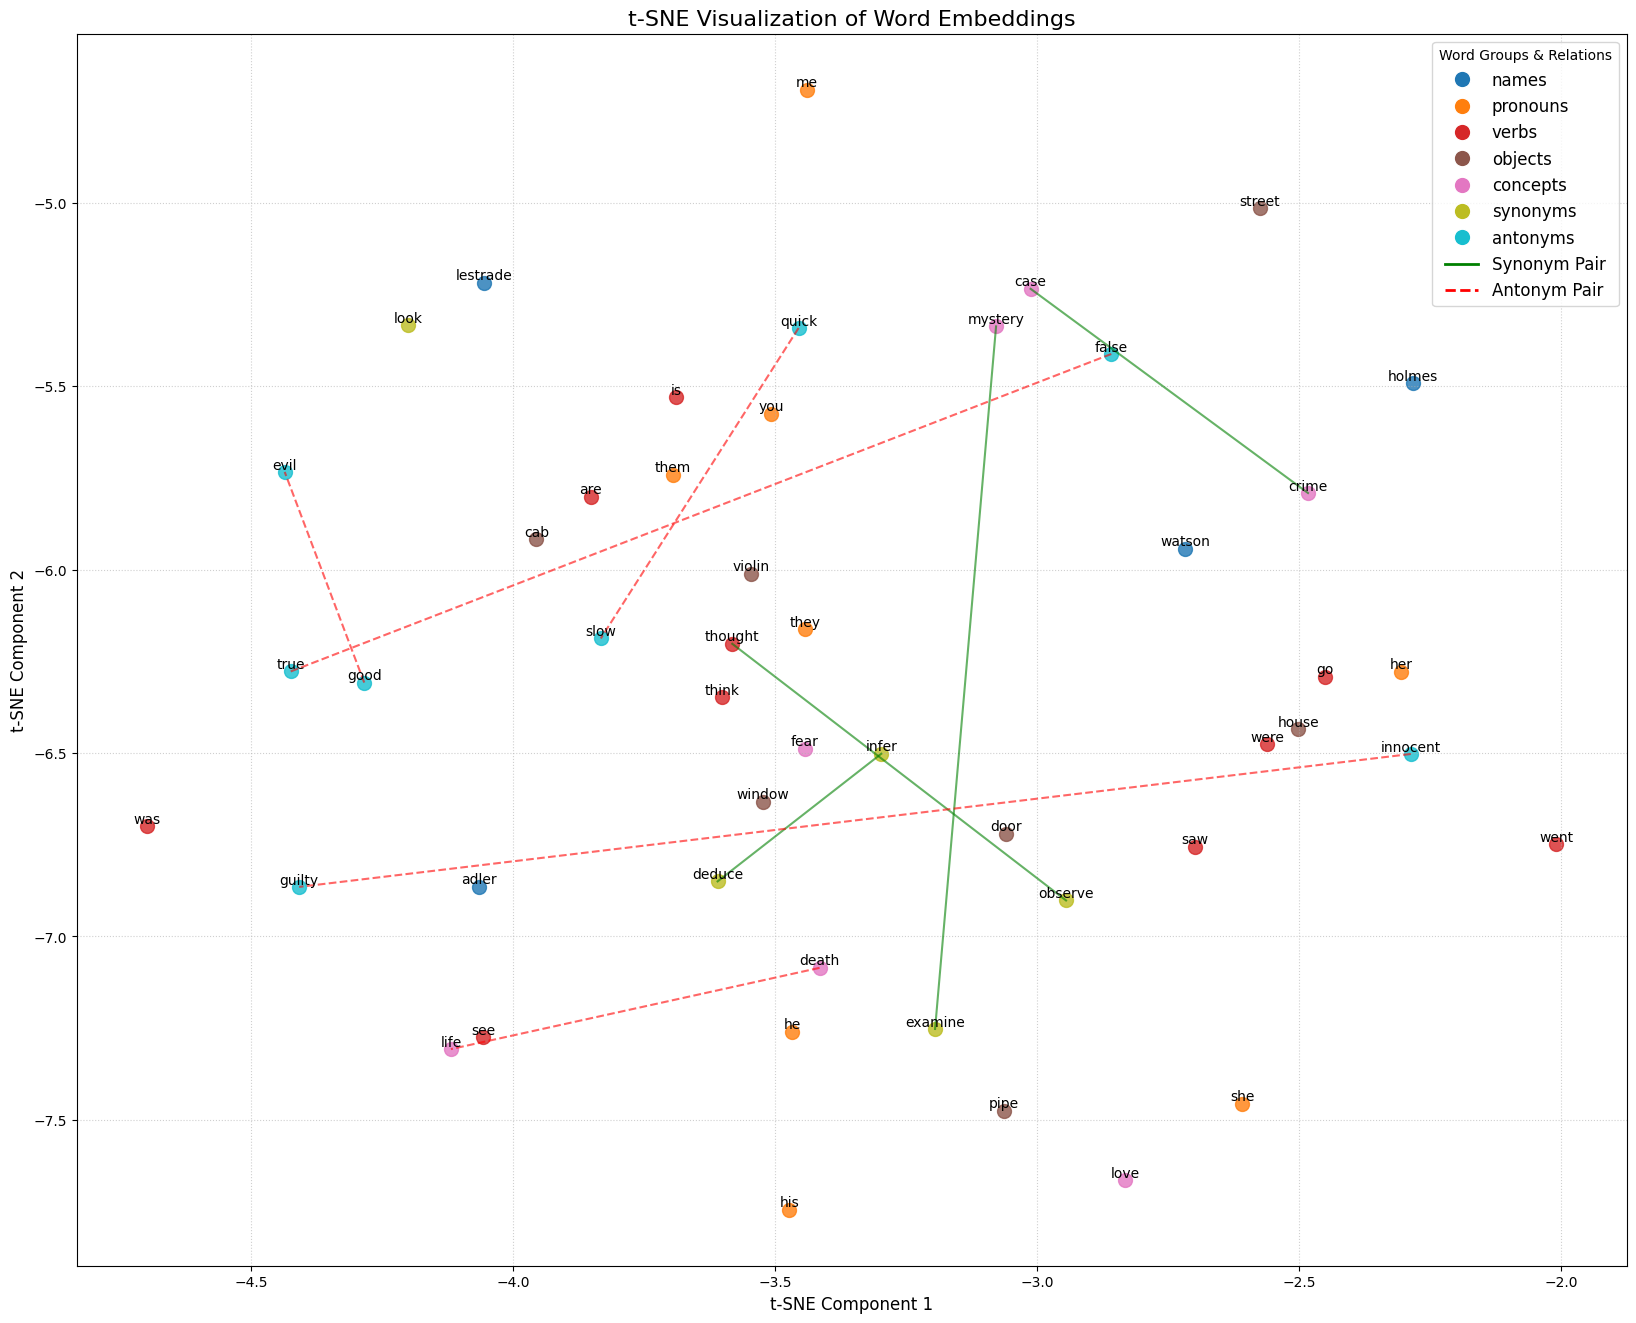

In [14]:
visualize_embeddings(model,stoi)

In [16]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# assuming these already exist
# X, Y, ctx_window, batch_size, test_size, device are defined

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)

# Wrap in TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("✅ train_loader and val_loader ready.")


✅ train_loader and val_loader ready.


In [17]:
EPOCHS = 20
val_loss, val_acc,loss_val, loss_train = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    EPOCHS,
    device
)

/tmp/ipykernel_558942/1390907882.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


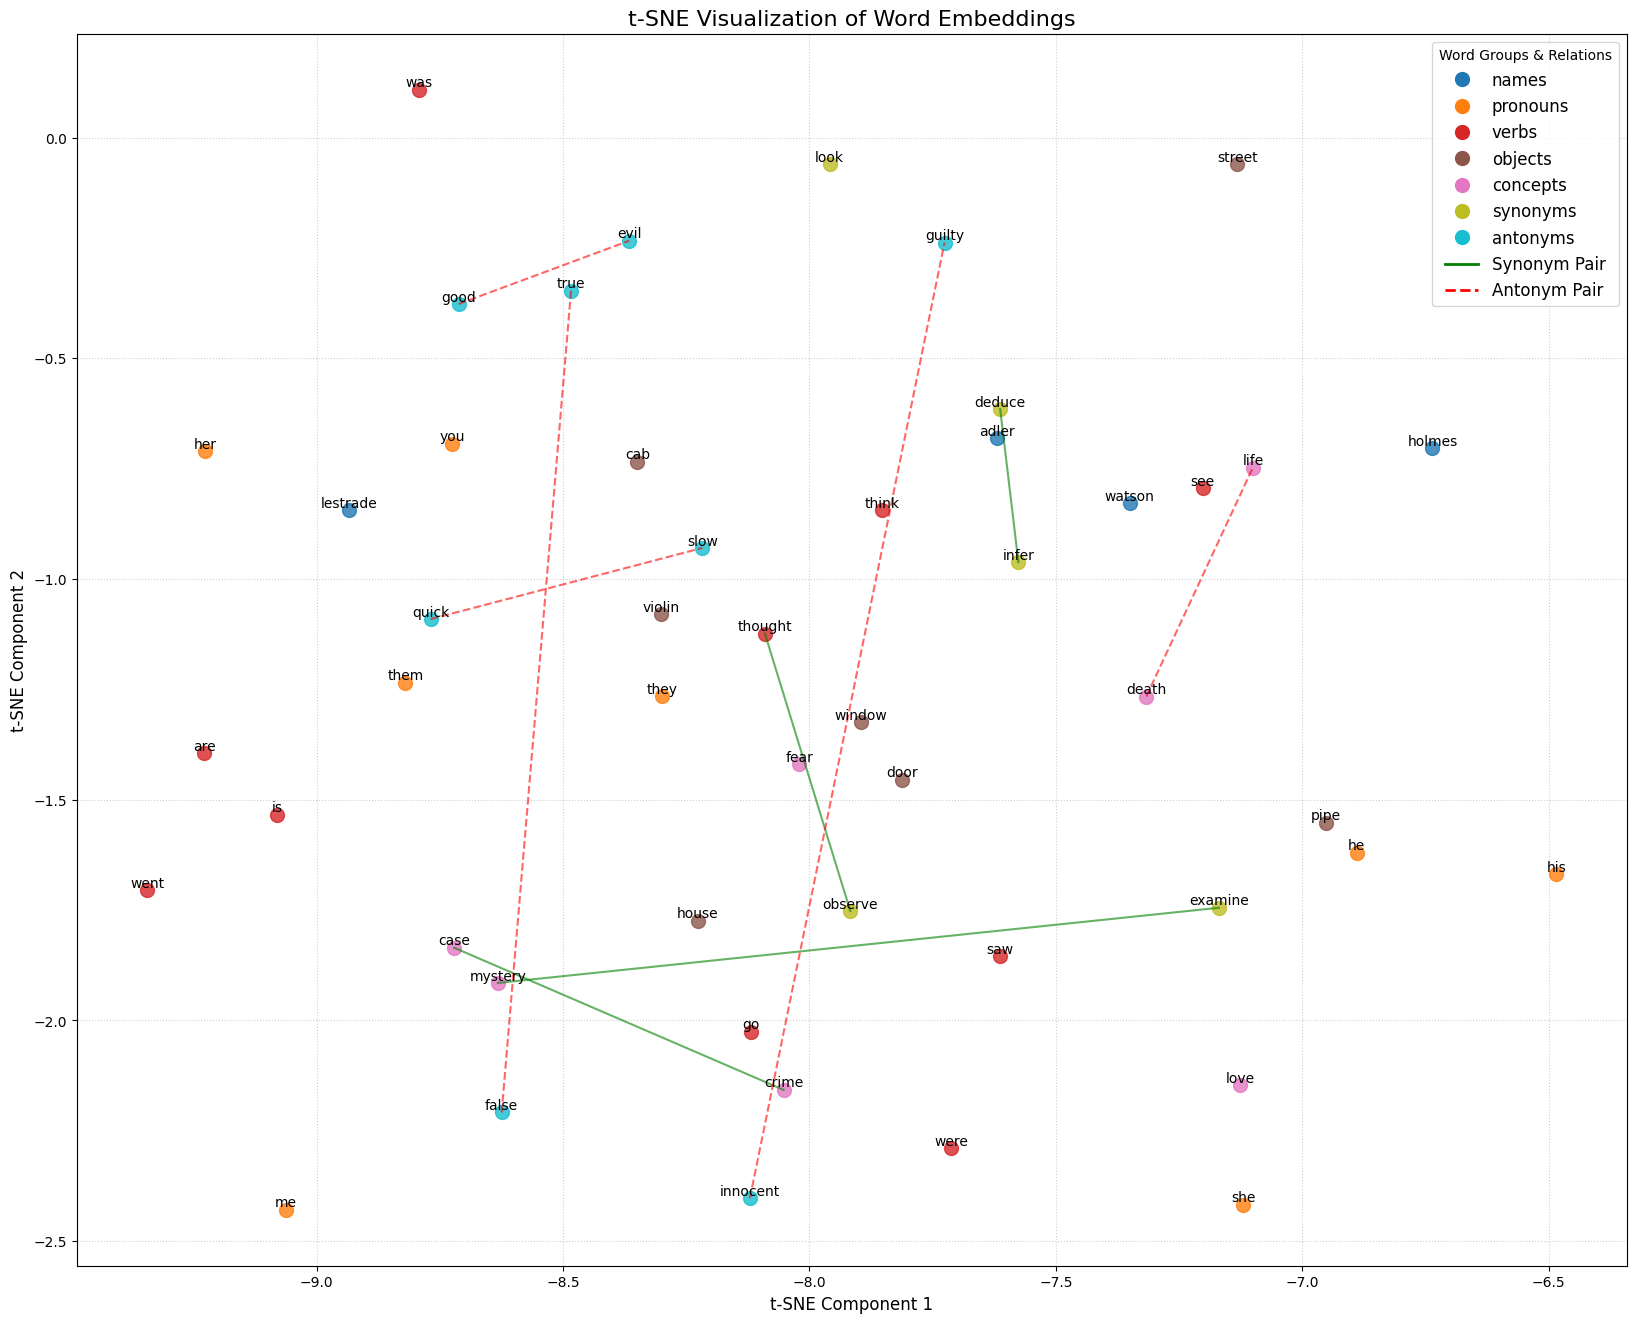

In [18]:
visualize_embeddings(model,stoi)

Best Validation Accuracy: 15.22%


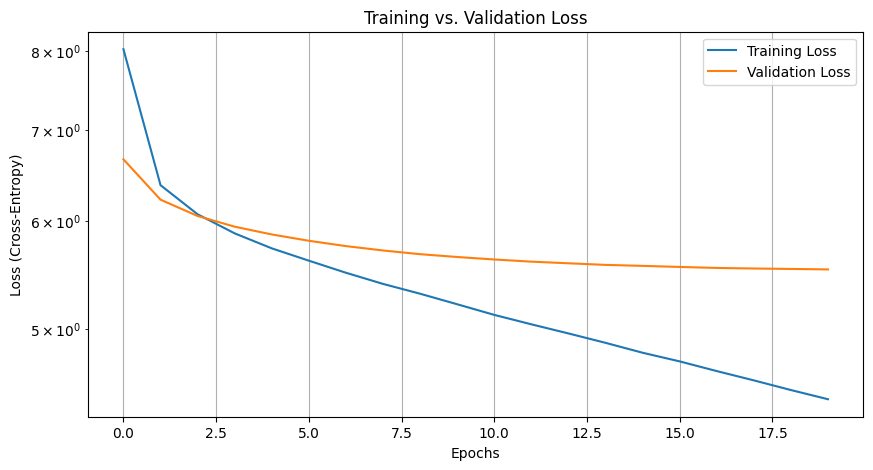

In [19]:
print(f"Best Validation Accuracy: {val_acc:.2f}%")
plt.figure(figsize=(10, 5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.yscale('log')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

The train loss saturates, lets increase the number of hidden neurons

#### Final Model

In [20]:
def generate_text(
    model,
    itos,
    stoi,
    ctx_window,
    device,
    prompt='',
    max_new_words = 100,
    temperature  = 1.0,
):
    if temperature <= 0:
        print("Warning: Temperature must be > 0. Setting to 1.0.")
        temperature = 1.0
    model.eval()
    prompt_words = prompt.split()
    context_indices = [
        stoi.get(word, 0) for word in prompt_words
    ]
    context = context_indices[-ctx_window:]
    if len(context) < ctx_window:
        context = [0] * (ctx_window - len(context)) + context

    generated_words = []

    with torch.no_grad():
        for _ in range(max_new_words):
            context_tensor = torch.tensor(context).view(1, -1).to(device)
            logits = model(context_tensor)
            scaled_logits = logits / temperature

            distribution = torch.distributions.categorical.Categorical(
                logits=scaled_logits
            )
            next_token_idx = distribution.sample().item()
            word = itos.get(next_token_idx)
            if word is None or word == "." or next_token_idx == 0:
                break

            generated_words.append(word)
            context = context[1:] + [next_token_idx]
    model.train()
    full_text = prompt_words + generated_words
    return " ".join(full_text)

In [21]:
embedding_dim = 64
hidden_dim = 1024
class MLPTextGenerator(nn.Module):
    def __init__(self, ctx_window, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # embedding layer
        self.fc1 = nn.Linear(embedding_dim * ctx_window, hidden_dim)  # first hidden layer
        self.act = nn.Tanh()  # activation function
        self.fc2 = nn.Linear(hidden_dim, vocab_size)  # output layer

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(x.shape[0], -1)  # flatten embeddings
        out = self.fc1(embeds)  # fully connected layer
        out = self.act(out)  # relu activation
        out = self.fc2(out)  # output
        return out

In [22]:
model = MLPTextGenerator(ctx_window, vocab_size, embedding_dim, hidden_dim).to(device)

In [23]:
for param_name, param in model.named_parameters():
    print(f"{param_name}: {param.shape}")

embedding.weight: torch.Size([7606, 64])
fc1.weight: torch.Size([1024, 384])
fc1.bias: torch.Size([1024])
fc2.weight: torch.Size([7606, 1024])
fc2.bias: torch.Size([7606])


In [24]:
print(generate_text(model,itos,stoi,ctx_window,device,'',30,temperature=2))

shall sobbing completed steady happy arteries chuckled kindness impertinent perfectly splendid treasure subscribe fasteners blotches conventionalities ship beryl author fortune age preference stock held escaped camberwell european from lighted waved


In [27]:
# Training!!!

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
model.to(device)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val, Y_val = X_val.to(device), Y_val.to(device)

train_loss_per_epoch = []
val_loss_per_epoch = []
val_acc_per_epoch = []

for epoch in tqdm(range(epochs), desc="Epochs", position=0):
    model.train()
    epoch_train_loss = 0.0
    for i in tqdm(range(0, X_train.shape[0], batch_size), 
                  desc=f"Training Epoch {epoch}", 
                  leave=False, 
                  position=1):

        x = X_train[i:i+batch_size]
        y = Y_train[i:i+batch_size]

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_val)
        val_loss = loss_fn(outputs, Y_val).item()
        _, predicted = torch.max(outputs, 1)
        val_acc = (predicted == Y_val).float().mean().item() * 100
    
    train_loss_per_epoch.append(epoch_train_loss)
    val_acc_per_epoch.append(val_acc)
    val_loss_per_epoch.append(val_loss)
    if epoch % 50 == 0:
        tqdm.write(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.2f}%"
        )

Epochs:   0%|          | 1/250 [00:00<01:46,  2.33it/s]

Epoch 000 | Train Loss: 67.5594 | Val Loss: 5.9027 | Val Acc: 13.73%


Epochs:  20%|██        | 51/250 [00:21<01:22,  2.40it/s]

Epoch 050 | Train Loss: 2.5866 | Val Loss: 8.3602 | Val Acc: 8.80%


Epochs:  40%|████      | 101/250 [00:41<01:02,  2.40it/s]

Epoch 100 | Train Loss: 0.4819 | Val Loss: 9.2205 | Val Acc: 9.83%


Epochs:  60%|██████    | 151/250 [01:02<00:41,  2.39it/s]

Epoch 150 | Train Loss: 0.2832 | Val Loss: 9.6719 | Val Acc: 9.86%


Epochs:  80%|████████  | 201/250 [01:23<00:20,  2.38it/s]

Epoch 200 | Train Loss: 0.2138 | Val Loss: 10.0129 | Val Acc: 9.79%


Epochs: 100%|██████████| 250/250 [01:44<00:00,  2.40it/s]


In [28]:
prompt = "it is cute"
text = generate_text(model,itos,stoi,ctx_window,device,prompt,30,temperature=1.7)

print(f"Prompt: {prompt}")
print(f"Generated text: {text}")

Prompt: it is cute
Generated text: it is cute and yet well


In [30]:
torch.save(model, "saved_models_q1/model1.pth")

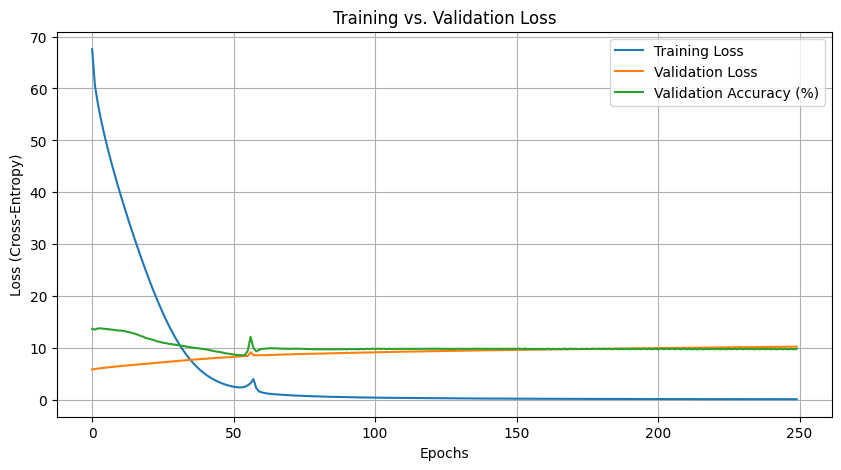

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.plot(val_acc_per_epoch,label='Validation Accuracy (%)')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()

#### Final Validation Loss, Accuracy

Using the elbow method, epoch = 100

In [32]:
print("Validation Loss",val_loss_per_epoch[99])
print("Validation Accuracy",val_acc_per_epoch[99], "%")

Validation Loss 9.212408065795898
Validation Accuracy 9.911520779132843 %


#### Example predictions and commentary on learning behavior.

### 1.3 Embedding Visualization and Interpretation [1 mark]


#### Random embeddings at model initialization

In [33]:
new_model = MLPTextGenerator(ctx_window, vocab_size, embedding_dim, hidden_dim).to(device)

/tmp/ipykernel_558942/1390907882.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


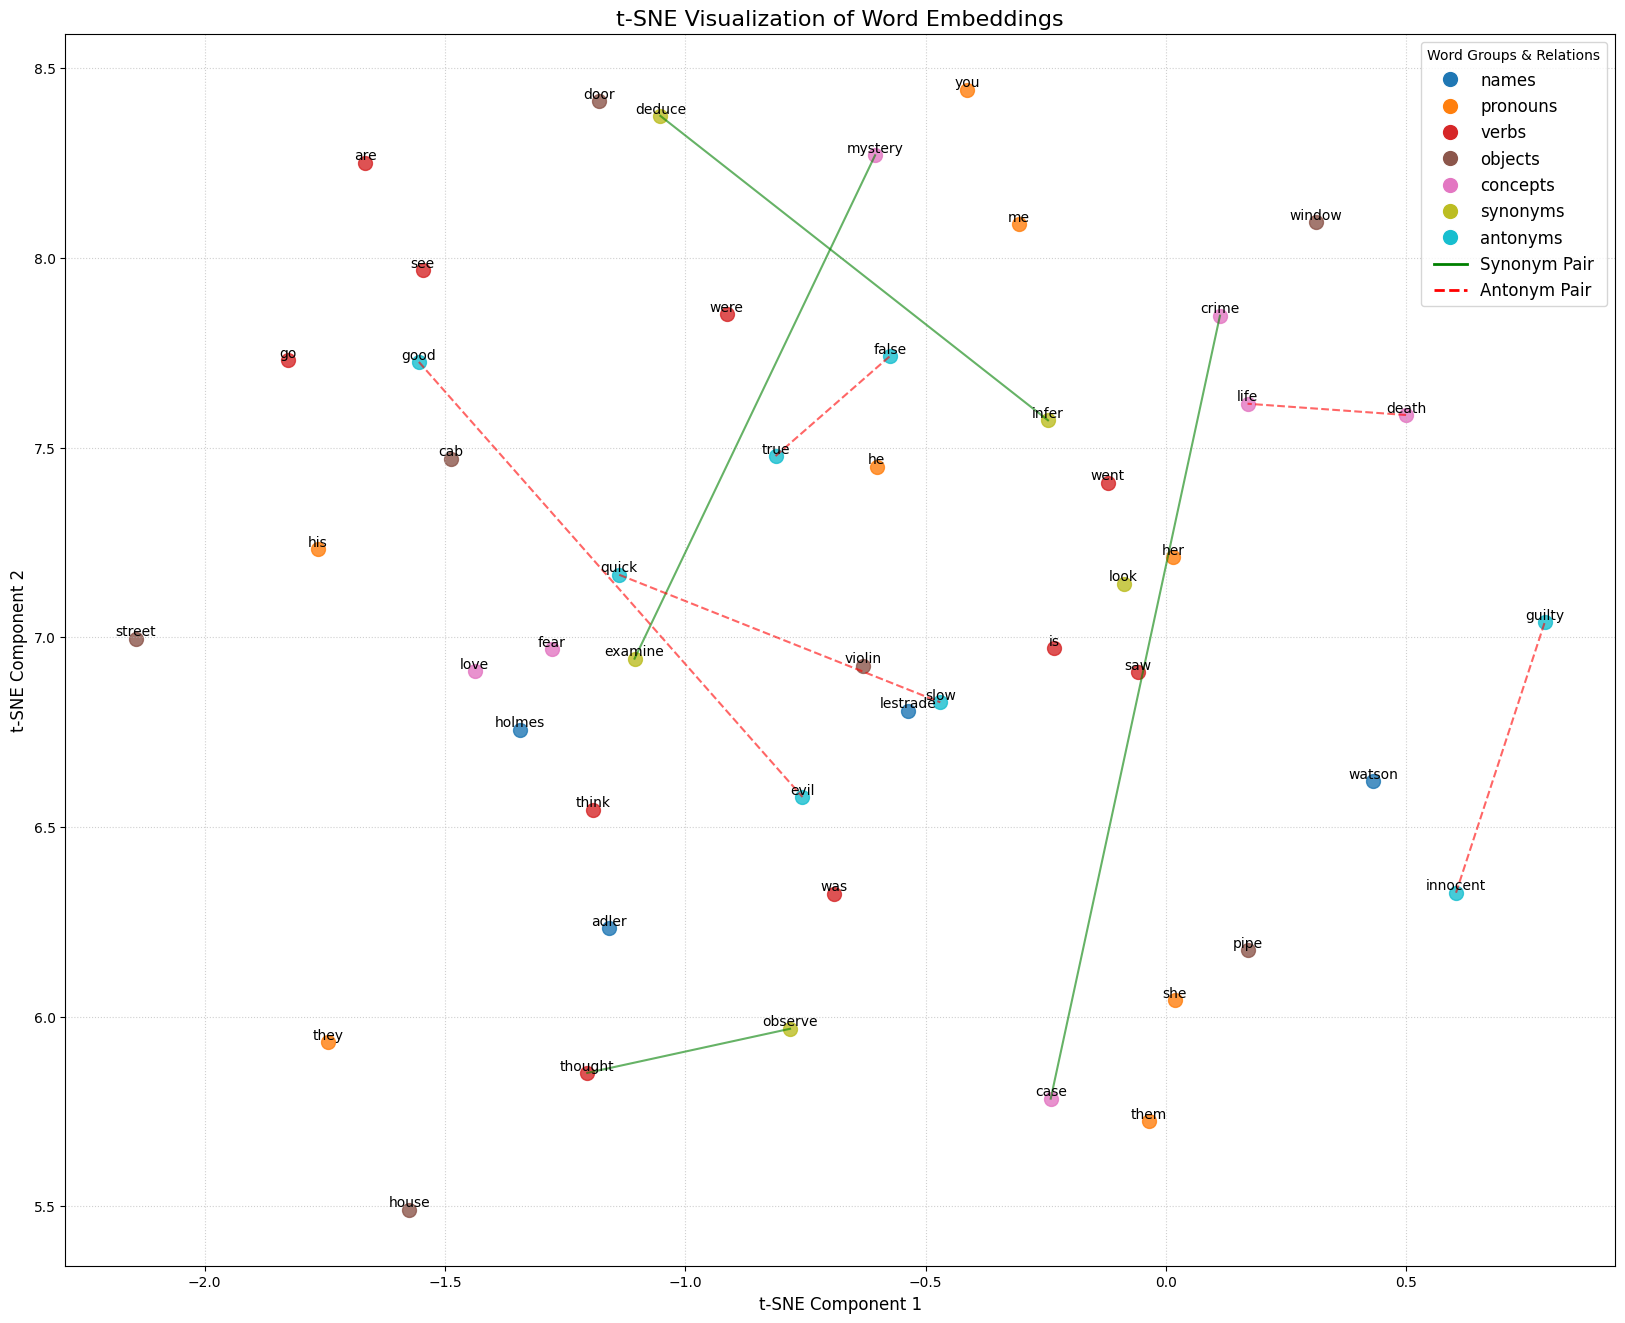

In [34]:
visualize_embeddings(new_model,stoi)

#### Learned Embeddigngs

/tmp/ipykernel_558942/1390907882.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


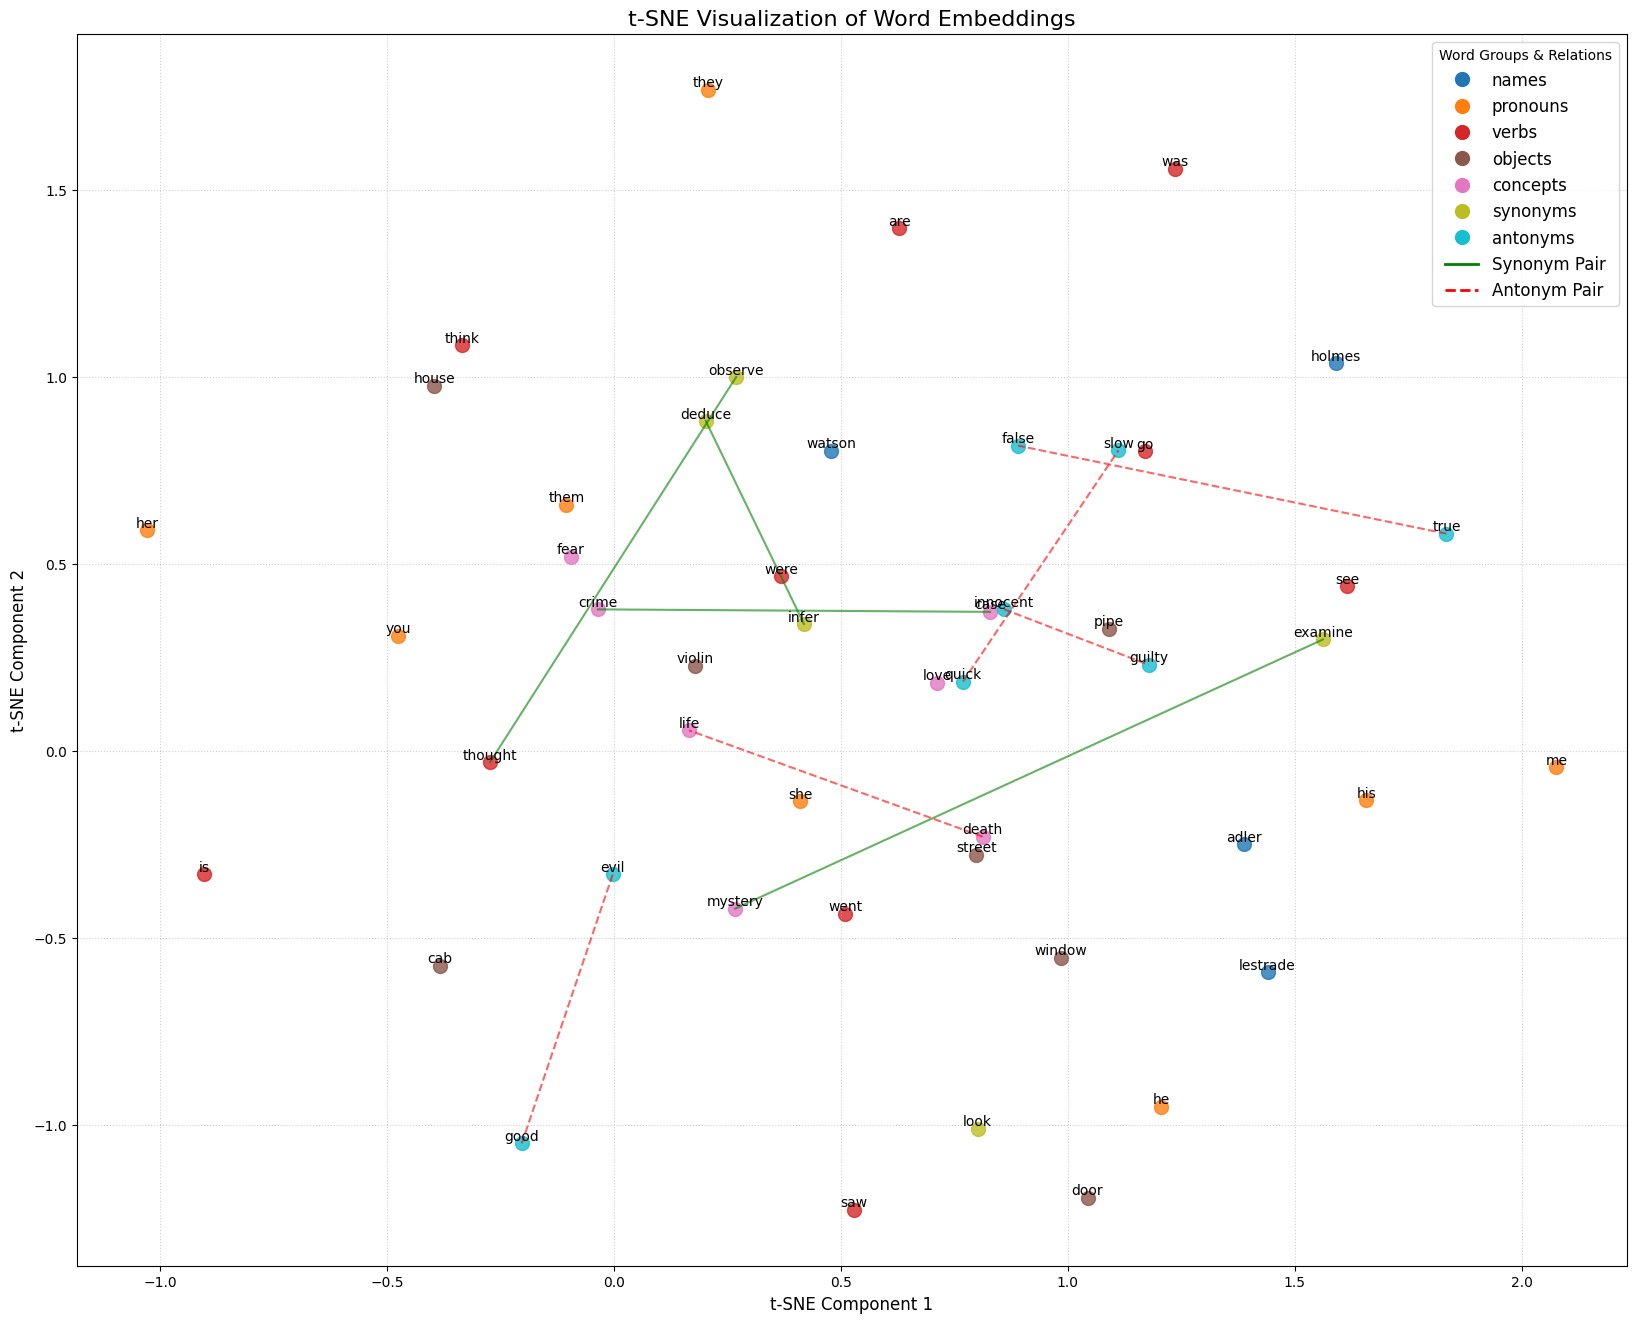

In [35]:
visualize_embeddings(model,stoi)

### 1.4 Streamlit Application [1.5 marks]
See [`./q1_streamlit.py`](./q1_streamlit.py)

#### Models: Category 1

In [36]:
_epochs = 120
embeddimg_dims = [32,64]
context_size = [4,8,12]
activations = [nn.ReLU(),nn.Tanh()]

class MLPTextGenerator_(nn.Module):
    def __init__(self, ctx_window, vocab_size, embedding_dim, hidden_dim,activation):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # embedding layer
        self.fc1 = nn.Linear(embedding_dim * ctx_window, hidden_dim)  # first hidden layer
        self.act = activation  # activation function
        self.fc2 = nn.Linear(hidden_dim, vocab_size)  # output layer

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(x.shape[0], -1)  # flatten embeddings
        out = self.fc1(embeds)  # fully connected layer
        out = self.act(out)  # relu activation
        out = self.fc2(out)  # output
        return out

for embedding_dim, ctx_sz,activation in itertools.product(embeddimg_dims,context_size,activations):
    X,Y,stoi,itos,_,_ = make_dataset(file_path,ctx_sz)
    vocab_size = len(stoi)
    X_train, X_val, Y_train, Y_val = train_test_split(
        X.cpu(), Y.cpu(), test_size=test_size, random_state=42
    )
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    
    model_ = MLPTextGenerator_(ctx_sz,len(stoi),embedding_dim,1024,activation)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model_.parameters(), lr=0.001)
    model_.to(device)
    train_loss_epch = []
    val_loss_epch = []
    val_acc_epch = []
    best_val_loss = float('inf')
    best_model_state = None
    for epoch in tqdm(range(_epochs), desc="Epochs", position=0):
        model_.train()
        epoch_train_loss = 0.0
        for i in tqdm(range(0, X_train.shape[0], batch_size), 
                    desc=f"Training Epoch {epoch}", 
                    leave=False, 
                    position=1):

            x = X_train[i:i+batch_size]
            y = Y_train[i:i+batch_size]

            y_pred = model_(x)
            loss = loss_fn(y_pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_train_loss += loss.item()
        train_loss_epch.append(epoch_train_loss)
        
        # Validation
        model_.eval()
        with torch.no_grad():
            outputs = model_(X_val)
            val_loss = loss_fn(outputs, Y_val).item()
            _, predicted = torch.max(outputs, 1)
            val_acc = (predicted == Y_val).float().mean().item() * 100
        if (epoch+1) % 60 == 0:
            tqdm.write(
                f"Epoch {epoch:03d} | "
                f"Train Loss: {epoch_train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Val Acc: {val_acc:.2f}%"
            )
        val_loss_epch.append(val_loss)
        val_acc_epch.append(val_acc)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model_.state_dict()
    with open(f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json','w') as f:
        f.write(json.dumps({'train_loss':train_loss_epch,'val_loss':val_loss_epch,'val_acc':val_acc_epch},indent=4))
        
    best_model_path = f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_best.pth'
    torch.save(best_model_state, best_model_path)

    final_model_path = f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_final.pth'
    torch.save(model_.state_dict(), final_model_path)   

Epochs:  50%|█████     | 60/120 [00:23<00:23,  2.51it/s]

Epoch 059 | Train Loss: 17.0549 | Val Loss: 10.3052 | Val Acc: 12.38%


Epochs: 100%|██████████| 120/120 [00:47<00:00,  2.52it/s]


Epoch 119 | Train Loss: 5.9167 | Val Loss: 13.1886 | Val Acc: 10.94%


Epochs:  50%|█████     | 60/120 [00:24<00:24,  2.46it/s]

Epoch 059 | Train Loss: 25.5693 | Val Loss: 7.2787 | Val Acc: 11.95%


Epochs: 100%|██████████| 120/120 [00:48<00:00,  2.47it/s]


Epoch 119 | Train Loss: 5.4787 | Val Loss: 8.8647 | Val Acc: 10.75%


Epochs:  50%|█████     | 60/120 [00:24<00:24,  2.47it/s]

Epoch 059 | Train Loss: 4.5488 | Val Loss: 11.3824 | Val Acc: 8.63%


Epochs: 100%|██████████| 120/120 [00:48<00:00,  2.47it/s]


Epoch 119 | Train Loss: 0.6256 | Val Loss: 14.0809 | Val Acc: 9.27%


Epochs:  50%|█████     | 60/120 [00:24<00:24,  2.43it/s]

Epoch 059 | Train Loss: 8.2357 | Val Loss: 8.0475 | Val Acc: 8.27%


Epochs: 100%|██████████| 120/120 [00:49<00:00,  2.43it/s]


Epoch 119 | Train Loss: 0.6935 | Val Loss: 9.4081 | Val Acc: 8.72%


Epochs:  50%|█████     | 60/120 [00:24<00:24,  2.43it/s]

Epoch 059 | Train Loss: 1.4133 | Val Loss: 11.7590 | Val Acc: 8.19%


Epochs: 100%|██████████| 120/120 [00:49<00:00,  2.43it/s]


Epoch 119 | Train Loss: 0.1702 | Val Loss: 13.3967 | Val Acc: 8.61%


Epochs:  50%|█████     | 60/120 [00:25<00:25,  2.39it/s]

Epoch 059 | Train Loss: 2.7985 | Val Loss: 8.4612 | Val Acc: 8.85%


Epochs: 100%|██████████| 120/120 [00:50<00:00,  2.39it/s]


Epoch 119 | Train Loss: 0.3406 | Val Loss: 9.4460 | Val Acc: 8.43%


Epochs:  50%|█████     | 60/120 [00:24<00:24,  2.46it/s]

Epoch 059 | Train Loss: 6.8332 | Val Loss: 10.6562 | Val Acc: 11.93%


Epochs: 100%|██████████| 120/120 [00:48<00:00,  2.47it/s]


Epoch 119 | Train Loss: 3.1360 | Val Loss: 12.5410 | Val Acc: 11.74%


Epochs:  50%|█████     | 60/120 [00:24<00:24,  2.43it/s]

Epoch 059 | Train Loss: 9.6291 | Val Loss: 7.7109 | Val Acc: 11.70%


Epochs: 100%|██████████| 120/120 [00:49<00:00,  2.43it/s]


Epoch 119 | Train Loss: 2.6726 | Val Loss: 9.0243 | Val Acc: 11.25%


Epochs:  50%|█████     | 60/120 [00:25<00:25,  2.38it/s]

Epoch 059 | Train Loss: 3.2300 | Val Loss: 11.7125 | Val Acc: 11.97%


Epochs: 100%|██████████| 120/120 [00:50<00:00,  2.39it/s]


Epoch 119 | Train Loss: 0.1362 | Val Loss: 12.2441 | Val Acc: 10.32%


Epochs:  50%|█████     | 60/120 [00:25<00:25,  2.35it/s]

Epoch 059 | Train Loss: 1.8408 | Val Loss: 8.3506 | Val Acc: 11.42%


Epochs: 100%|██████████| 120/120 [00:50<00:00,  2.36it/s]


Epoch 119 | Train Loss: 0.2253 | Val Loss: 8.9026 | Val Acc: 10.05%


Epochs:  50%|█████     | 60/120 [00:25<00:26,  2.30it/s]

Epoch 059 | Train Loss: 0.2656 | Val Loss: 10.9085 | Val Acc: 10.02%


Epochs: 100%|██████████| 120/120 [00:51<00:00,  2.31it/s]


Epoch 119 | Train Loss: 0.0628 | Val Loss: 11.9846 | Val Acc: 9.69%


Epochs:  50%|█████     | 60/120 [00:26<00:26,  2.27it/s]

Epoch 059 | Train Loss: 0.6049 | Val Loss: 8.2315 | Val Acc: 10.27%


Epochs: 100%|██████████| 120/120 [00:52<00:00,  2.28it/s]

Epoch 119 | Train Loss: 0.1198 | Val Loss: 8.7993 | Val Acc: 9.54%


In [37]:
for embedding_dim, ctx_sz,activation in itertools.product(embeddimg_dims,context_size,activations):
    X,Y,stoi,itos,_,_ = make_dataset(file_path,ctx_sz)
    with open(f'./saved_models_q1/stoi_sherlock.json','w') as f:
        f.write(json.dumps(stoi,indent=4))
    break

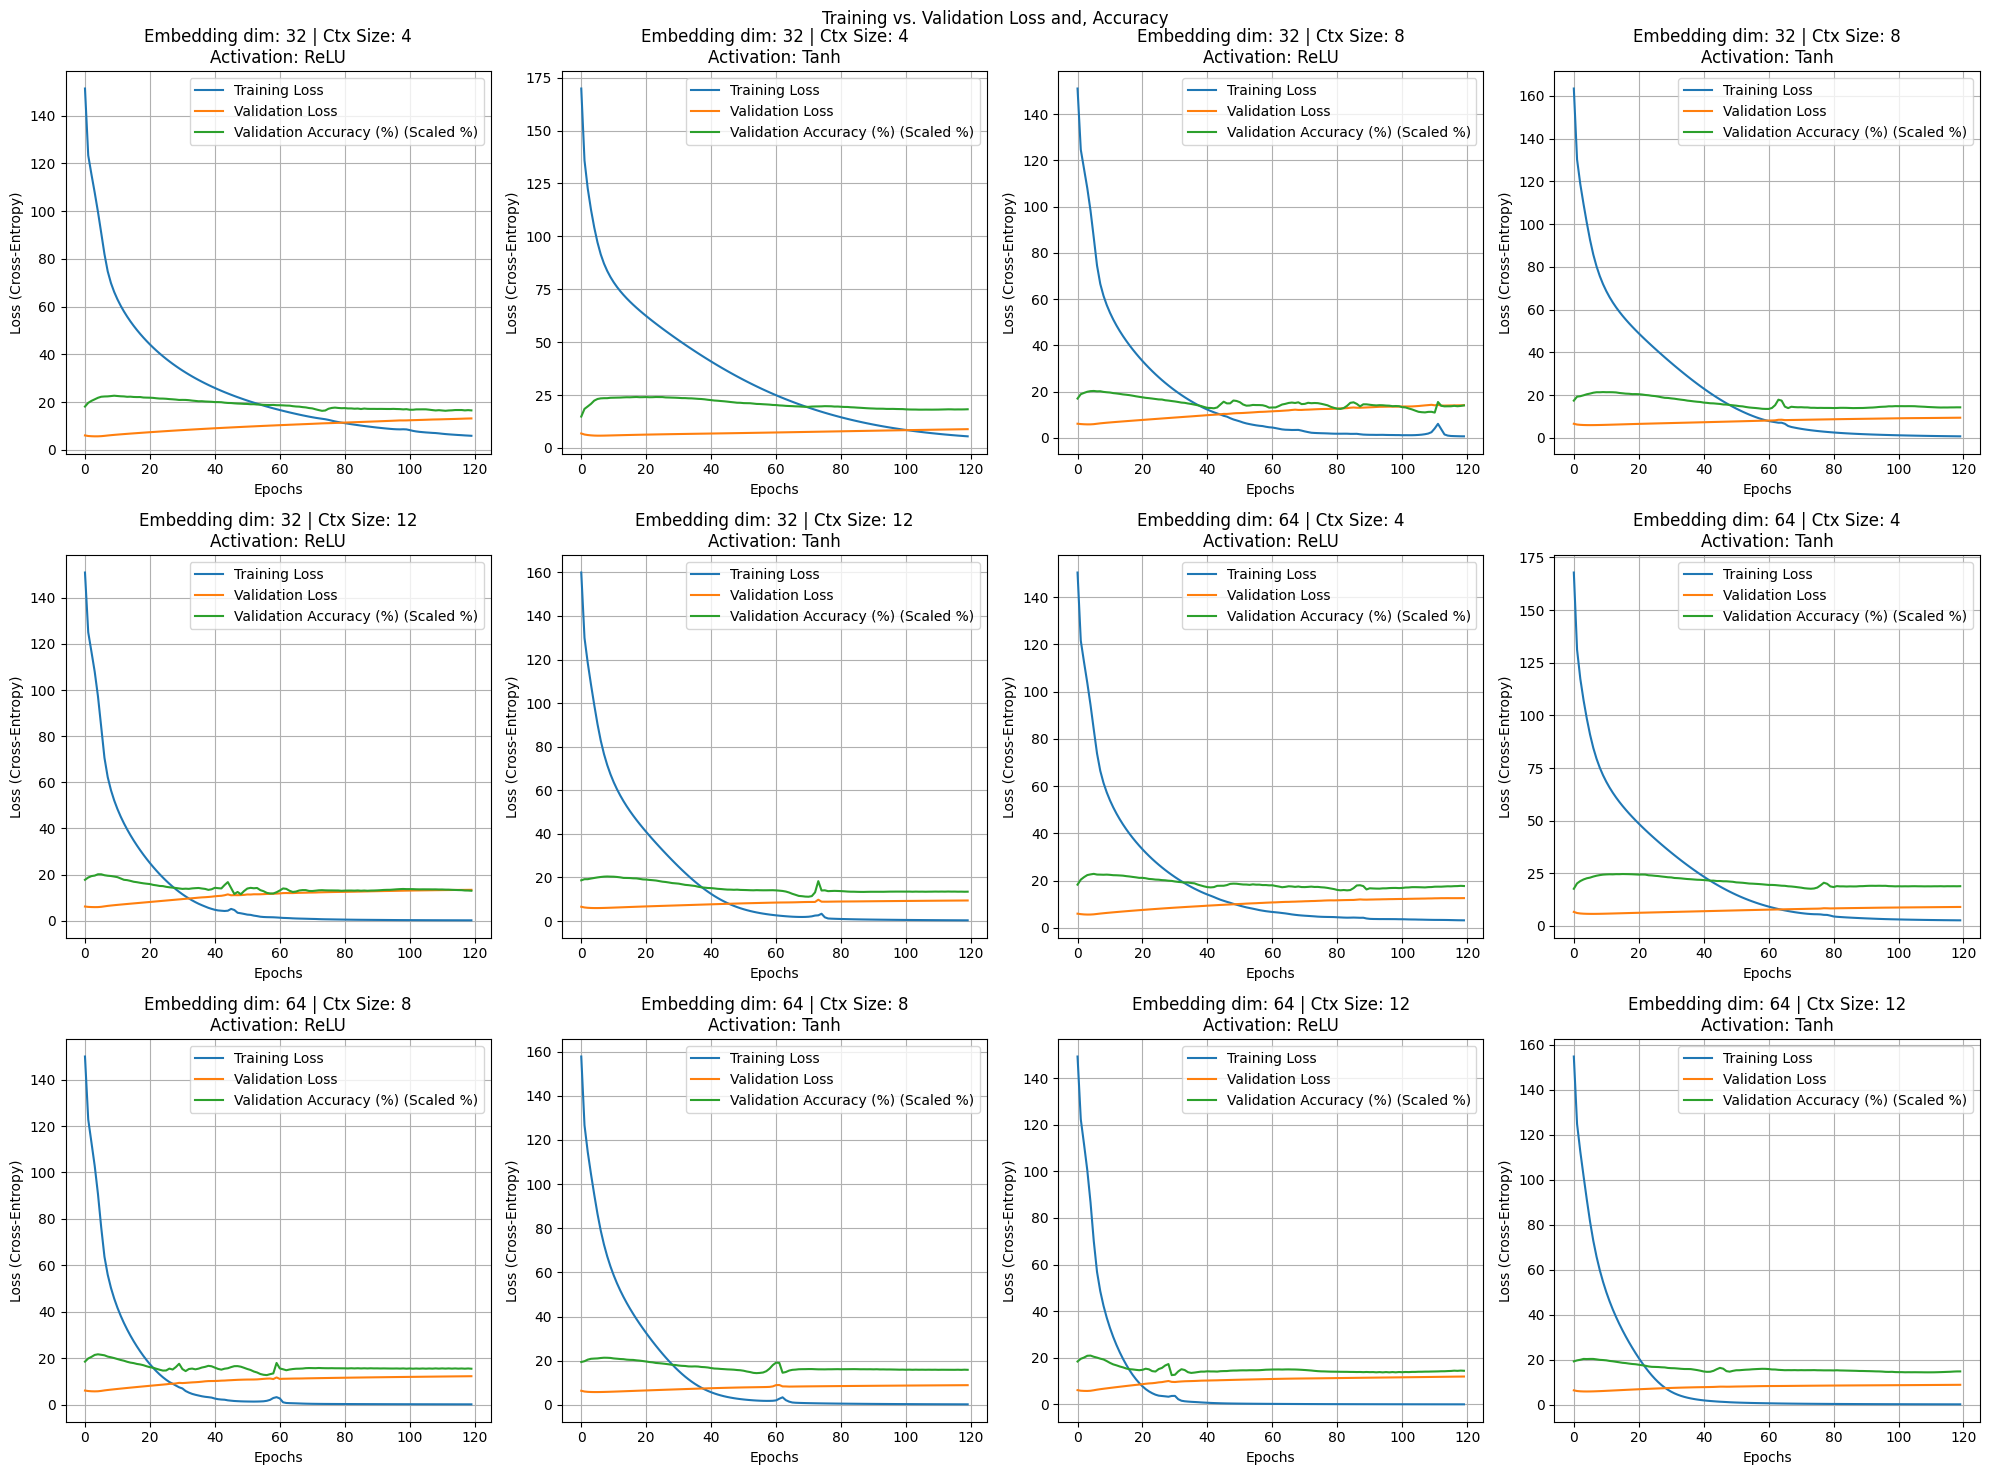

In [38]:
def plot(log = False):
    plt.figure(figsize=(20,15))
    for idx, (embedding_dim, ctx_sz,activation) in enumerate(itertools.product(embeddimg_dims,context_size,activations),1):
        plt.subplot(3,4,idx)
        with open(f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json','r') as f:
            data = json.load(f)
            tr_lss_arr = data['train_loss']
            val_lss_arr = data['val_loss']
            val_acc_arr = data['val_acc']
        plt.plot(tr_lss_arr, label='Training Loss')
        plt.plot(val_lss_arr, label='Validation Loss')
        plt.plot(np.array(val_acc_arr)/100 * max(np.max(tr_lss_arr),np.max(val_lss_arr)),label='Validation Accuracy (%) (Scaled %)')
        plt.title(f'Embedding dim: {embedding_dim} | Ctx Size: {ctx_sz}\nActivation: {activation._get_name()}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Cross-Entropy)')
        if log:
            plt.yscale('log')
        plt.legend()
        plt.grid(True)
    plt.suptitle('Training vs. Validation Loss and, Accuracy')
    plt.tight_layout()
    plt.show()
plot()

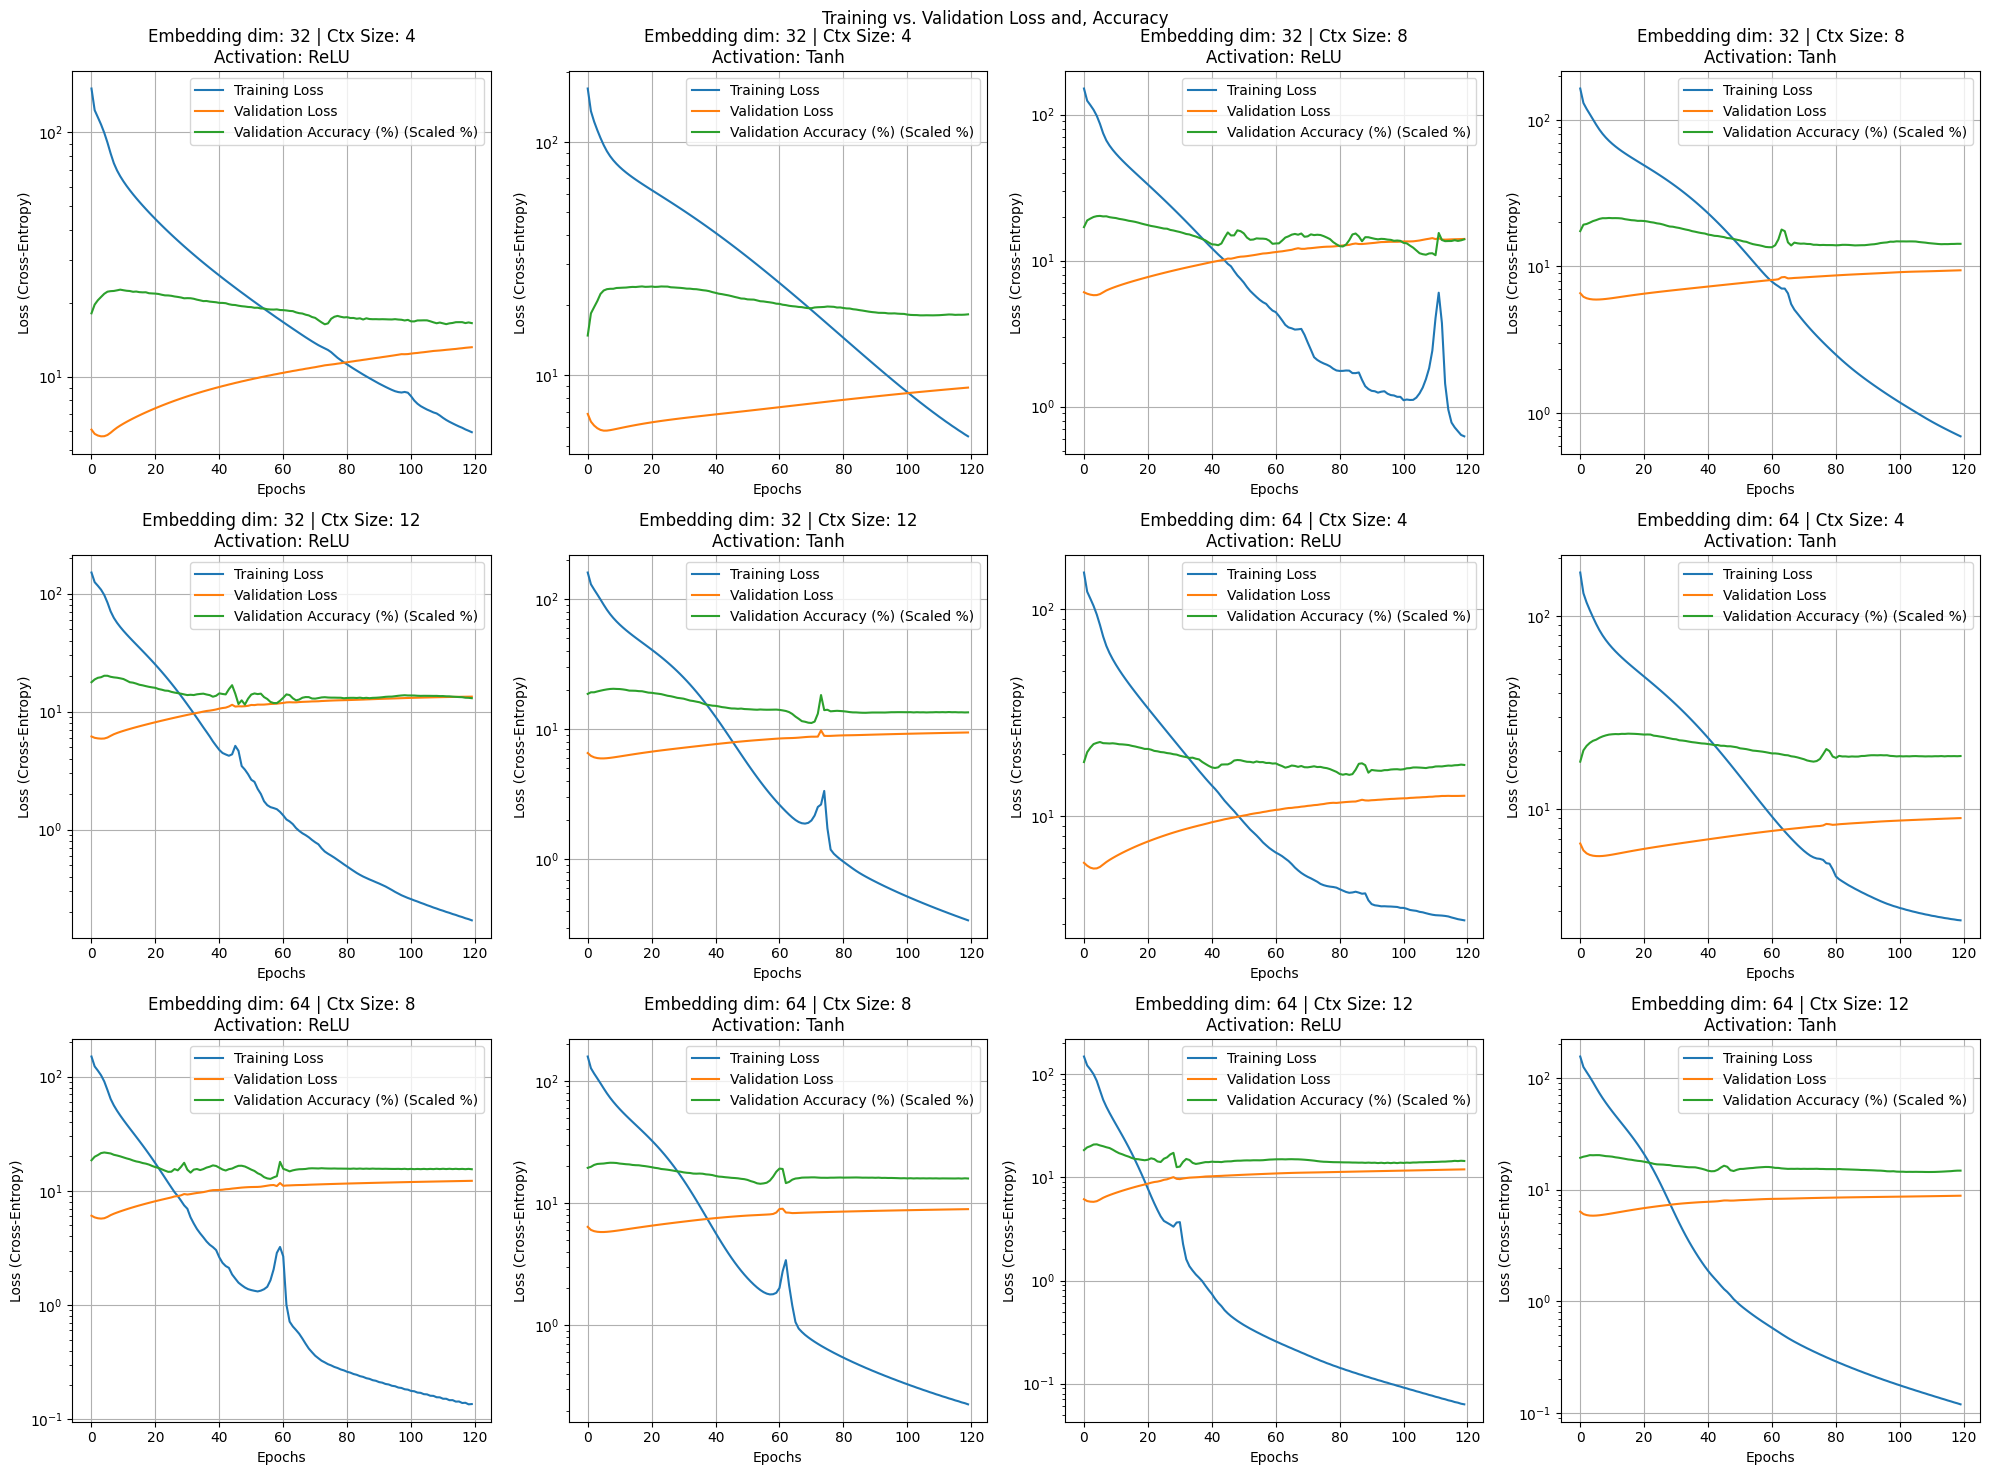

In [39]:
plot(True)

#### Best Model Category 1

In [40]:
best_model_path

'./saved_models_q1/e64_c12_aTanh_best.pth'

/tmp/ipykernel_558942/1390907882.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


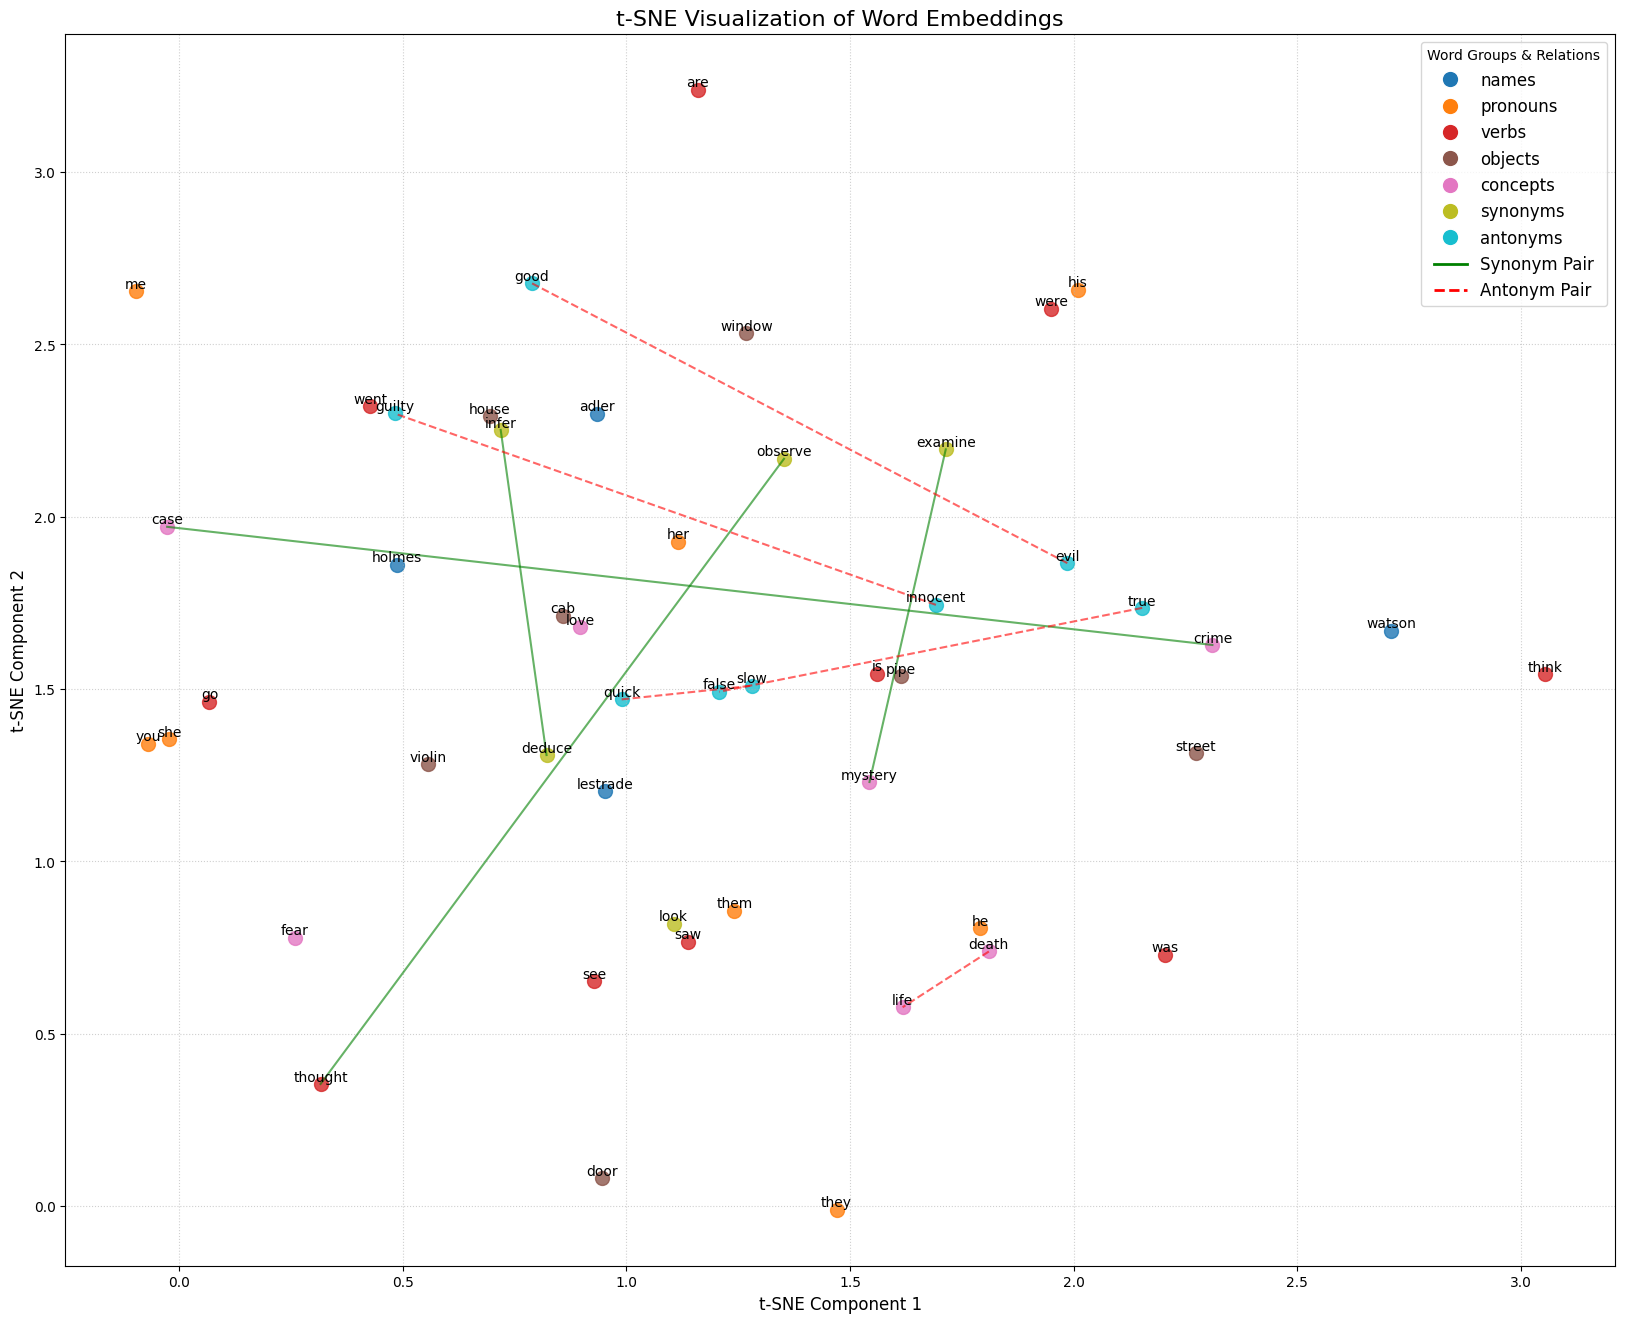

In [42]:
loaded_model = MLPTextGenerator_(
    ctx_window=12,         # not 4
    vocab_size=vocab_size,
    embedding_dim=64,      # not 32
    hidden_dim=1024,
    activation=nn.ReLU()
).to(device)

loaded_model.load_state_dict(best_model_state)
loaded_model.eval()

visualize_embeddings(loaded_model, stoi)


## Category 2: Linux Kernel Code                

### 1.1 Preprocessing and Vocabulary Construction [0.5 mark]

In [43]:
def tokenize_c_code(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        code = f.read()
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    code = re.sub(r'//.*', '', code)

    token_patterns = [
        ('INCL', r'#include'), 
        ('HEAD',   r'<[^>]+>'), #headers
        ('PREP', r'#\s*(define|ifdef|ifndef|endif)'), # preprocessor
        ('KWRD', r'\b(auto|break|case|char|const|continue|default|do|double|else|enum|extern|'
                r'float|for|goto|if|inline|int|long|register|restrict|return|short|signed|sizeof|'
                r'static|struct|switch|typedef|union|unsigned|void|volatile|while)\b'), # keywords
        ('IDFR', r'\b[A-Za-z_][A-Za-z0-9_]*\b'), # identifiers
        ('NMBR', r'\b\d+(\.\d+)?\b'), # numbers
        ('STRN', r'\"(?:\\.|[^\"\\\\])*\"'), # strings
        ('OPRT', r'==|!=|<=|>=|->|&&|\|\||\+\+|--|[+\-*/%=&|<>!~^]'), # trivial operators
        ('DLMT', r'[;:,.\\[\\]\\(\\)\\{\\}]'), # delimiters
        ('NEWL', r'\n'), # new line
        ('WHSP', r'[ \t]+'), # whitespaces
        ('MTAN', r'.'), # anything else. (match anytbning)
    ]
    master_pattern = re.compile('|'.join(f'(?P<{name}>{pattern})' for name, pattern in token_patterns))
    
    tokens = []
    for match in master_pattern.finditer(code):
        token_type = match.lastgroup
        token_value = match.group()
        if token_type == 'NEWL':
            tokens.append('\\n')
        elif token_type == 'WHSP':
            tokens.append('\\s')
        elif token_type != 'MTAN':
            tokens.append(token_value)
    return tokens

file_path = 'question1_datasets/linux_kernel_code.txt'
all_tokens = tokenize_c_code(file_path)

vocab = sorted(list(set(all_tokens)))
stoi = {s: i + 1 for i, s in enumerate(vocab)}
stoi['<UNKN>'] = 0 # unkown token
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

word_counts = Counter(all_tokens)
most_common = word_counts.most_common(10)
least_common = word_counts.most_common()[:-11:-1]

print(f"Vocabulary Size: {vocab_size}")
print("\n10 Most Frequent Tokens:")
for token, count in most_common:
    print(f"{repr(token)}: {count}")

print("\n10 Least Frequent Tokens:")
for token, count in least_common:
    print(f"{repr(token)}: {count}")

def make_dataset(ctx_sz, stoi):
    X, Y = [], []
    for i in range(len(all_tokens) - ctx_sz):
        context = all_tokens[i : i + ctx_sz]
        target = all_tokens[i + ctx_sz]
        X.append([stoi.get(t, stoi['<UNKN>']) for t in context])
        Y.append(stoi.get(target, stoi['<UNKN>']))

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

Vocabulary Size: 28791

10 Most Frequent Tokens:
'\\s': 284792
'\\n': 150800
'->': 24312
'=': 22108
'*': 17461
'struct': 13414
'if': 11456
'&': 11028
'return': 7888
'int': 7476

10 Least Frequent Tokens:
'context_tracking_init': 1
'CONFIG_CONTEXT_TRACKING_FORCE': 1
'__context_tracking_task_switch': 1
'CONTEXT_KERNEL': 1
'trace_user_exit': 1
'vtime_user_exit': 1
'trace_user_enter': 1
'<trace/events/context_tracking.h>': 1
'kstat_irqs_usr': 1
'kstat_incr_irq_this_cpu': 1


In [44]:
def visualize_code_embeddings(model, stoi):
    code_groups = {
        'types': ['int', 'char', 'void', 'struct', 'long', 'unsigned'],
        'control': ['if', 'else', 'for', 'while', 'return', 'break', 'switch'],
        'operators': ['+', '-', '*', '/', '=', '->', '&', '|', '=='],
        'delimiters': ['(', ')', '{', '}', '[', ']', ';', ','],
        'preprocessor': ['#include', '#define', '#ifdef', '#endif']
    }
    
    words_to_plot = []
    group_labels = []
    for group, words in code_groups.items():
        for word in words:
            if word in stoi and word not in words_to_plot:
                words_to_plot.append(word)
                group_labels.append(group)
    
    embeddings = model.embedding.weight.data.cpu().numpy()
    word_indices = [stoi[word] for word in words_to_plot]
    selected_embeddings = embeddings[word_indices]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(word_indices)-1))
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    plt.figure(figsize=(16, 12))
    unique_groups = list(code_groups.keys())
    colors = plt.cm.get_cmap('tab10', len(unique_groups))
    group_to_color = {group: colors(i) for i, group in enumerate(unique_groups)}
    
    for i, word in enumerate(words_to_plot):
        x, y = embeddings_2d[i]
        group = group_labels[i]
        plt.scatter(x, y, color=group_to_color[group], s=100)
        plt.annotate(repr(word).strip("'"), (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group,
                                  markerfacecolor=group_to_color[group], markersize=10)
                       for group in unique_groups]
    plt.legend(handles=legend_elements, title="Token Groups")
    plt.title('t-SNE Visualization of C Code Token Embeddings')
    plt.show()

### 1.2 Model Design and Training [1 marks]

In [45]:
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, context_window, activation_fn):
        super(MLPTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_window * embedding_dim, hidden_dim)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x).view(x.shape[0], -1)
        out = self.activation(self.fc1(embedded))
        return self.fc2(out)

def train(model, optimizer, criterion, epochs,ctx_sz,stoi,activation,save=True):
    X,Y = make_dataset(ctx_sz,stoi)
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
    train_losses, val_losses = [], []
    val_accuracy = []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in tqdm(
            train_loader,
            desc=f"Train [{epoch+1}/{epochs}] {train_losses[-1] if len(train_losses) > 0 else ''}",
            position=0,
            leave=False
        ):
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in tqdm(
                val_loader,
                desc=f"Val [{epoch+1}/{epochs}] {val_losses[-1] if len(val_losses) > 0 else ''}",
                position=0,
                leave=False
            ):
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()
        
        val_losses.append(epoch_val_loss)
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)
        if (epoch+1) % 20 == 0:
            tqdm.write(
                f"Epoch {epoch:03d} | "
                f"Train Loss: {epoch_train_loss:.4f} | "
                f"Val Loss: {epoch_val_loss:.4f} | "
                f"Val Acc: {accuracy:.2f}%"
            )
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
    if save:
        with open(f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json','w') as f:
            f.write(json.dumps({'train_loss':train_losses,'val_loss':val_losses,'val_acc':val_accuracy},indent=4))
            
        best_model_path = f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_best.pth'
        torch.save(best_model_state, best_model_path)

        final_model_path = f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_final.pth'
        torch.save(model.state_dict(), final_model_path)

    return train_losses, val_losses, val_accuracy   

In [46]:
ctx_sz = 8
model = MLPTextGenerator(vocab_size, 32, 1024, ctx_sz, nn.ReLU()).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, final_accuracy = train(model, optimizer, criterion, 100,ctx_sz,stoi,nn.ReLU(),save=False)

Epoch 019 | Train Loss: 120.5265 | Val Loss: 136.5695 | Val Acc: 59.83%


Epoch 039 | Train Loss: 73.6900 | Val Loss: 162.3216 | Val Acc: 60.23%


Epoch 059 | Train Loss: 54.2118 | Val Loss: 188.1357 | Val Acc: 59.81%


Epoch 079 | Train Loss: 46.3051 | Val Loss: 210.0007 | Val Acc: 59.62%


Epoch 099 | Train Loss: 42.7097 | Val Loss: 227.1178 | Val Acc: 59.49%


In [48]:
with open(f'./saved_models_q1_2/stoi_linux.json','w') as f:
    f.write(json.dumps(stoi,indent=4))

In [49]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

30695255


In [50]:
torch.save(model.state_dict(), f'./saved_models_q1_2/model1.pth')

Loading the saved model

In [51]:
ctx_sz = 8
model = MLPTextGenerator(vocab_size, 32, 1024, ctx_sz, nn.ReLU()).to(device)
model.load_state_dict(torch.load('./saved_models_q1_2/model1.pth', map_location='cpu'))
model.to(device)

/tmp/ipykernel_558942/3744575278.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./saved_models_q1_2/model1.pth', map_location='cpu'))


MLPTextGenerator(
  (embedding): Embedding(28791, 32)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=1024, out_features=28791, bias=True)
)

Example Predictions

In [52]:
def tokenize_prompt_string(prompt_code):
    token_specification = [
        ('INCL', r'#include'),
        ('HEAD',   r'<[^>]+>'),
        ('PREP', r'#\s*(define|ifdef|ifndef|endif)'),
        ('KWRD', r'\b(auto|break|case|char|const|continue|default|do|double|else|enum|extern|'
                r'float|for|goto|if|inline|int|long|register|restrict|return|short|signed|sizeof|'
                r'static|struct|switch|typedef|union|unsigned|void|volatile|while)\b'),
        ('IDFR', r'\b[A-Za-z_][A-Za-z0-9_]*\b'),
        ('NMBR', r'\b\d+(\.\d+)?\b'),
        ('STRN', r'\"(?:\\.|[^\"\\\\])*\"'),
        ('OPRT', r'==|!=|<=|>=|->|&&|\|\||\+\+|--|[+\-*/%=&|<>!~^]'),
        ('DLMT', r'[;:,.\\[\\]\\(\\)\\{\\}]'),
        ('NEWL', r'\n'),
        ('WHSP', r'[ \t]+'),
        ('MTAN', r'.'),
    ]
    master_pattern = re.compile('|'.join(f'(?P<{name}>{pattern})' for name, pattern in token_specification))
    tokens = []
    for match in master_pattern.finditer(prompt_code):
        token_type = match.lastgroup
        if token_type == 'NEWL':
            tokens.append('\\n')
        elif token_type == 'WHSP':
            tokens.append('\\s')
        elif token_type != 'MTAN':
            tokens.append(match.group())
    return tokens

def generate_code(model, itos, stoi, context_words, block_size, max_len=20):
    model.eval()
    unk_idx = stoi.get('<UNKN>', 0)
    context = [stoi.get(word, unk_idx) for word in context_words]
    
    if len(context) < block_size:
        context = [unk_idx] * (block_size - len(context)) + context
    generated_code = ''
    with torch.no_grad():
        for _ in range(max_len):
            x = torch.tensor(context[-block_size:]).unsqueeze(0).to(device)
            y_pred = model(x)
            probs = F.softmax(y_pred, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            word = itos.get(ix, '<UNKN>')
            if ix == unk_idx:
                break
            context.append(ix)
            if word == '\\n':
                generated_code += '\n'
            elif word == '\\s':
                generated_code += ' '
            else:
                generated_code += word

    return generated_code


code_contexts = [
    "int *p =",
    "*p = ",
    "if (a == NULL) {",
    "free(",
    "node->next = new_node;",
    "typedef struct {",
    "printf(",
    "for (int i = 0;",
    "fseek(fp, 0, SEEK_END);",
    "pthread_create(&",
    "int main() {"
]

for idx, context_str in enumerate(code_contexts, 1):    
    generated_sequence = generate_code(
        model=model,
        itos=itos,
        stoi=stoi,
        context_words=tokenize_prompt_string(context_str),
        block_size=ctx_sz,
        max_len=50  
    )
    
    print(f"--- Sequence {idx} ---")
    print(f"Context: {context_str}")
    print(f"Generated code sequence:\n{context_str}{generated_sequence}\n")

--- Sequence 1 ---
Context: int *p =
Generated code sequence:
int *p = *per_cpu_ptrdata->on + len
 if t 
 arg->tp++ parg
 false data
 void *current->task_state_change
 if exe_file  
 void *info

--- Sequence 2 ---
Context: *p = 
Generated code sequence:
*p = list->node

 tsk->files = newf
 error = 0
out
 return err


int __init struct syscall_metadata *
find_syscall_metaunsigned long syscall

 struct

--- Sequence 3 ---
Context: if (a == NULL) {
Generated code sequence:
if (a == NULL) {
 VERBOSE_TOROUT_ERRSTRING"writer_tasks: Out of memory"tsk *p
 return  p->copy += cputime

 ca = parent_caca
 
 rcu_read_unlock


static void
ring_buffer_initstruct ring_buffer *rb 

--- Sequence 4 ---
Context: free(
Generated code sequence:
free(list keylist list  list->ip prints l void 0 seq = void __user * buf

 struct workqueue_struct *wq = rescuer->wq

 

--- Sequence 5 ---
Context: node->next = new_node;
Generated code sequence:
node->next = new_node;!val
 return NULL

EXPORT_SYMBOL_GPL__ring_buffe

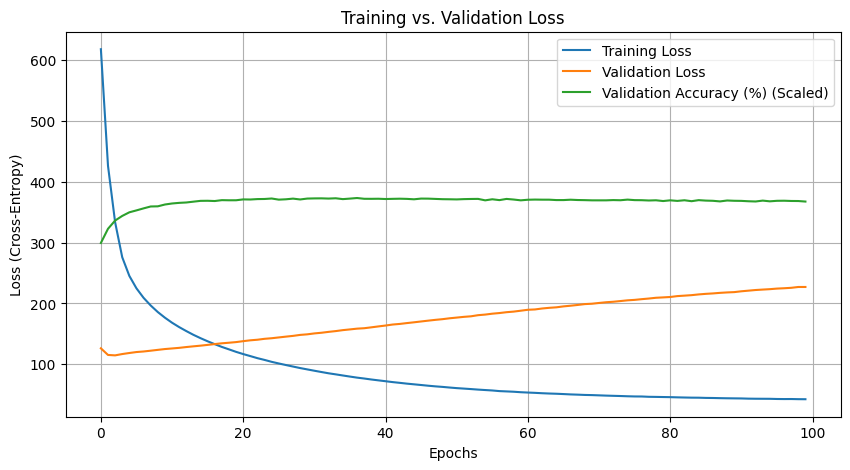

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(np.array(final_accuracy)/100*max(np.max(train_losses),np.max(val_losses)),label='Validation Accuracy (%) (Scaled)')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()

### 1.3 Embedding Visualization and Interpretation [1 mark]


#### Random embeddings at model initialization

In [54]:
new_model =  MLPTextGenerator(vocab_size, 32, 1024, 8, nn.ReLU()).to(device)

/tmp/ipykernel_558942/2817235563.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


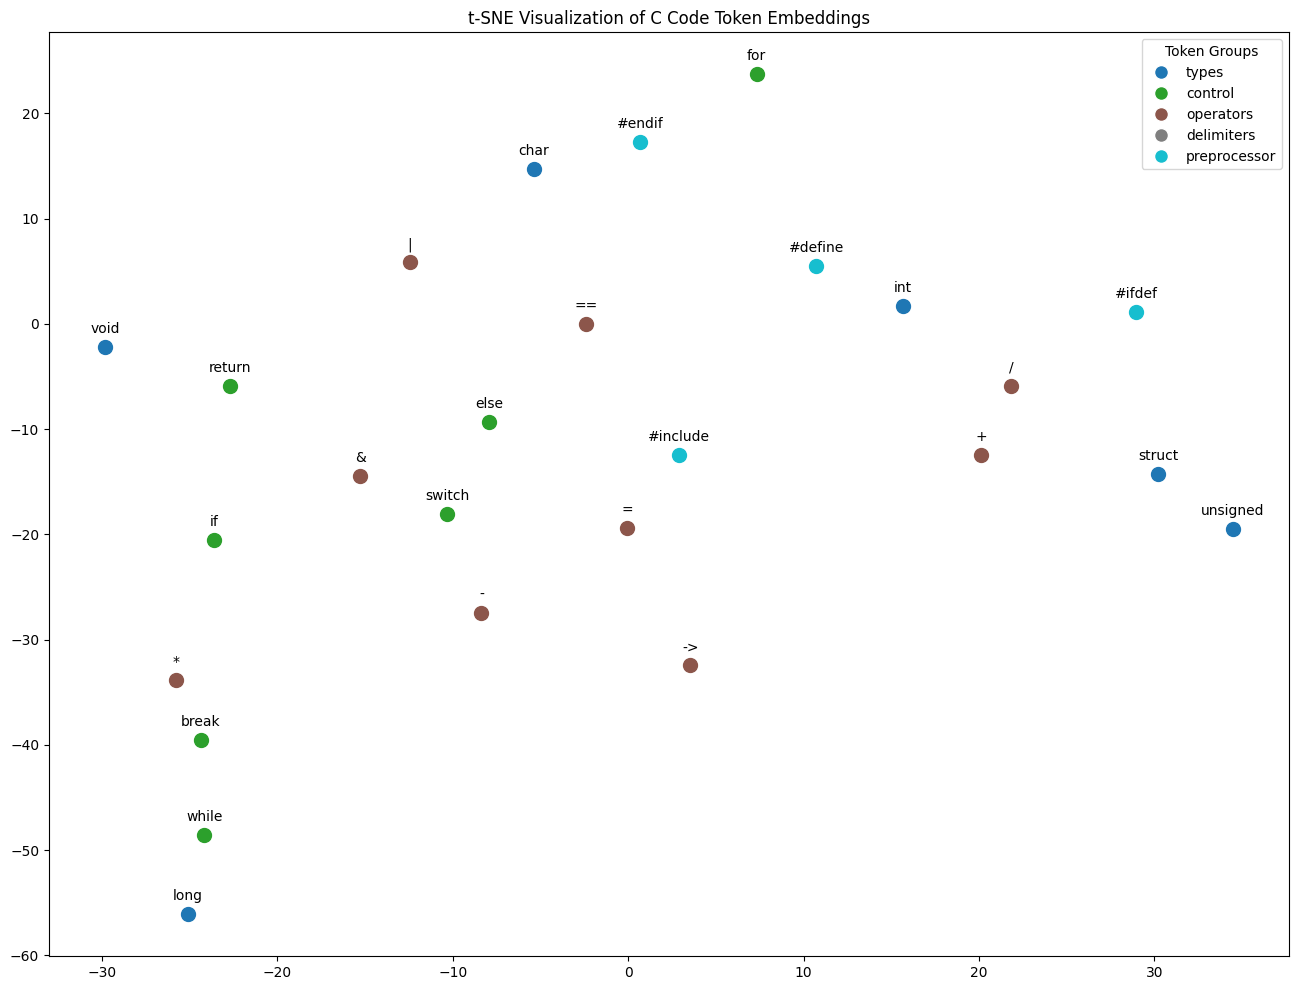

In [55]:
visualize_code_embeddings(new_model, stoi)

#### Learned Embeddings

/tmp/ipykernel_558942/2817235563.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


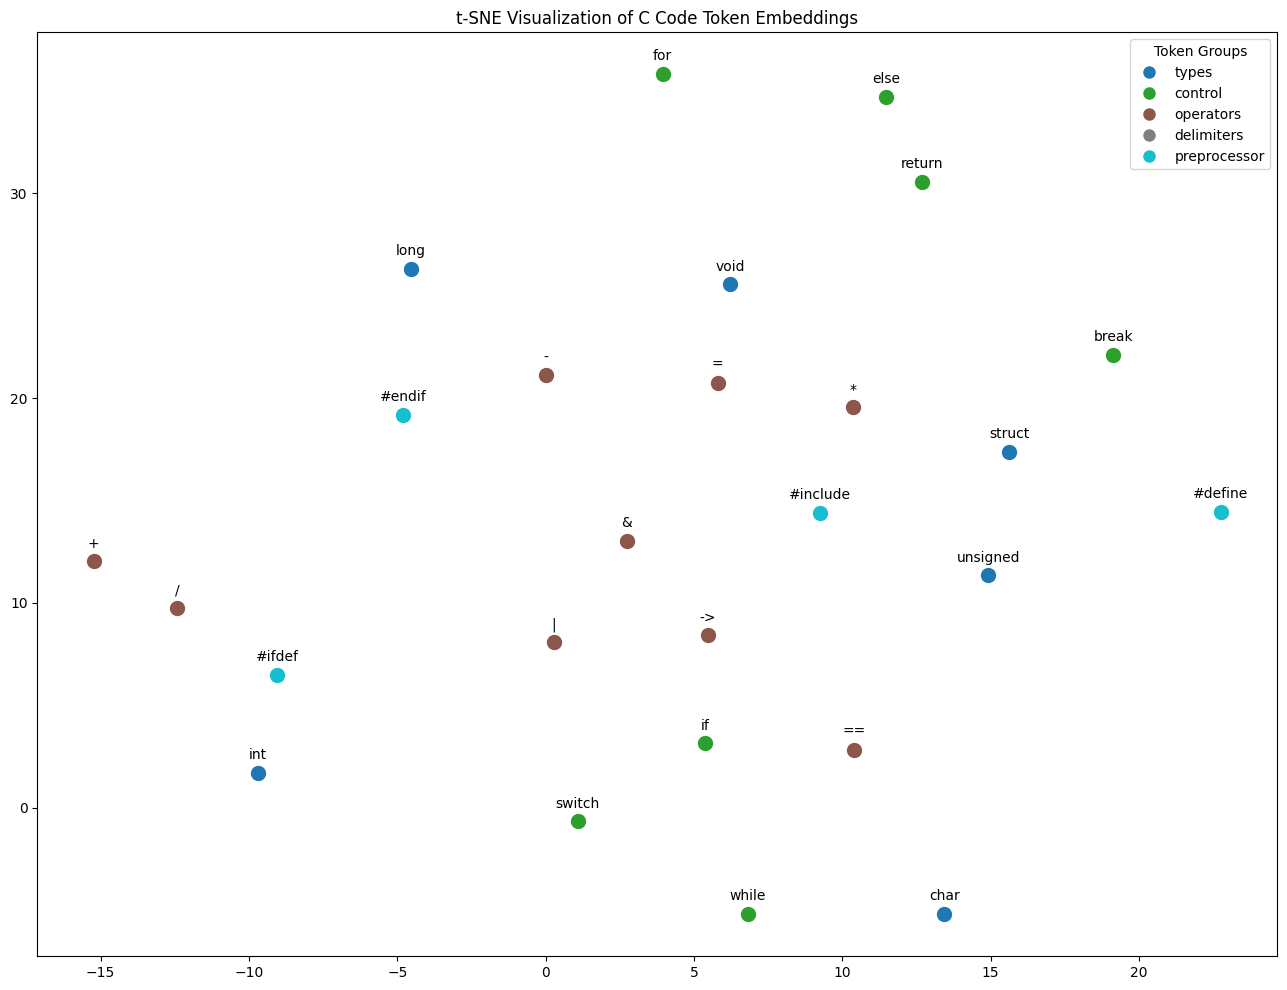

In [56]:
visualize_code_embeddings(model, stoi)

### 1.4 Streamlit Application [1.5 marks]
See [`./q1_streamlit.py`](./q1_streamlit.py)

#### Models: Category 2

In [57]:
_epochs = 100
embeddimg_dims = [32,64]
context_size = [4,8,12]
activations = [nn.ReLU(),nn.Tanh()]

class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, context_window, activation_fn):
        super(MLPTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_window * embedding_dim, hidden_dim)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x).view(x.shape[0], -1)
        out = self.activation(self.fc1(embedded))
        return self.fc2(out)

for embedding_dim, ctx_sz,activation in itertools.product(embeddimg_dims,context_size,activations):
    if embedding_dim == 32:
        continue
    model_ = MLPTextGenerator(vocab_size, embedding_dim, 1024, ctx_sz, activation).to(device)
    optimizer = optim.Adam(model_.parameters())
    criterion = nn.CrossEntropyLoss()
    _, _, _ = train(model_, optimizer, criterion, _epochs,ctx_sz,stoi,activation)

Epoch 019 | Train Loss: 206.7359 | Val Loss: 124.3324 | Val Acc: 57.74%


Epoch 039 | Train Loss: 175.2906 | Val Loss: 139.6810 | Val Acc: 57.99%


Epoch 059 | Train Loss: 167.0140 | Val Loss: 152.2736 | Val Acc: 57.91%


Epoch 079 | Train Loss: 163.6235 | Val Loss: 163.4285 | Val Acc: 57.88%


Epoch 099 | Train Loss: 161.6715 | Val Loss: 173.7872 | Val Acc: 58.02%


Epoch 019 | Train Loss: 238.7316 | Val Loss: 116.4690 | Val Acc: 57.03%


Epoch 039 | Train Loss: 200.9521 | Val Loss: 123.8023 | Val Acc: 57.85%


Epoch 059 | Train Loss: 188.7197 | Val Loss: 129.2299 | Val Acc: 57.83%


Epoch 079 | Train Loss: 184.2528 | Val Loss: 132.3424 | Val Acc: 57.69%


Epoch 099 | Train Loss: 181.9310 | Val Loss: 134.0400 | Val Acc: 57.44%


Epoch 019 | Train Loss: 88.5471 | Val Loss: 136.7970 | Val Acc: 61.07%


Epoch 039 | Train Loss: 50.3718 | Val Loss: 164.1108 | Val Acc: 60.89%


Epoch 059 | Train Loss: 43.0770 | Val Loss: 183.4204 | Val Acc: 60.67%


Epoch 079 | Train Loss: 40.0235 | Val Loss: 198.9754 | Val Acc: 60.67%


Epoch 099 | Train Loss: 38.2403 | Val Loss: 215.4029 | Val Acc: 60.51%


Epoch 019 | Train Loss: 106.4553 | Val Loss: 117.8456 | Val Acc: 60.89%


Epoch 039 | Train Loss: 61.0912 | Val Loss: 138.4887 | Val Acc: 60.66%


Epoch 059 | Train Loss: 55.3920 | Val Loss: 150.1085 | Val Acc: 60.32%


Epoch 079 | Train Loss: 53.5742 | Val Loss: 155.6145 | Val Acc: 60.51%


Epoch 099 | Train Loss: 52.8193 | Val Loss: 158.9213 | Val Acc: 60.39%


Epoch 019 | Train Loss: 43.2547 | Val Loss: 152.9987 | Val Acc: 60.98%


Epoch 039 | Train Loss: 18.8573 | Val Loss: 183.4661 | Val Acc: 60.86%


Epoch 059 | Train Loss: 15.6054 | Val Loss: 196.1272 | Val Acc: 60.67%


Epoch 079 | Train Loss: 13.7278 | Val Loss: 213.0404 | Val Acc: 60.45%


Epoch 099 | Train Loss: 12.3845 | Val Loss: 228.5525 | Val Acc: 60.35%


Epoch 019 | Train Loss: 56.1756 | Val Loss: 118.9142 | Val Acc: 61.48%


Epoch 039 | Train Loss: 22.0738 | Val Loss: 145.4788 | Val Acc: 60.87%


Epoch 059 | Train Loss: 20.2625 | Val Loss: 158.2247 | Val Acc: 60.99%


Epoch 079 | Train Loss: 19.1497 | Val Loss: 164.5240 | Val Acc: 60.94%


Epoch 099 | Train Loss: 18.5296 | Val Loss: 170.0546 | Val Acc: 60.75%


In [58]:
jsons = [ f'./saved_models_q1_2/{i}' for i in os.listdir('./saved_models_q1_2/') if i.endswith('.json')]
datas = {i:None for i in jsons}
for i in jsons:
    with open(i) as f:
        d = json.load(f)
        datas[i] = d

In [60]:
def plot(log=False):
    plt.figure(figsize=(20,15))
    idx = 1
    for embedding_dim, ctx_sz, activation in itertools.product(embeddimg_dims, context_size, activations):
        if embedding_dim == 32:   # ✅ skip missing ones
            continue
        plt.subplot(3, 2, idx)
        with open(f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json', 'r') as f:
            data = json.load(f)
            tr_lss_arr = data['train_loss']
            val_lss_arr = data['val_loss']
            val_acc_arr = data['val_acc']
        plt.plot(tr_lss_arr, label='Training Loss')
        plt.plot(val_lss_arr, label='Validation Loss')
        plt.plot(np.array(val_acc_arr)/100 * max(np.max(tr_lss_arr), np.max(val_lss_arr)),
                 label='Validation Accuracy (%) (Scaled %)')
        plt.title(f'Embedding dim: {embedding_dim} | Ctx Size: {ctx_sz}\nActivation: {activation._get_name()}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Cross-Entropy)')
        if log:
            plt.yscale('log')
        plt.legend()
        plt.grid(True)
        idx += 1
    plt.suptitle('Training vs. Validation Loss and Accuracy')
    plt.tight_layout()
    plt.show()


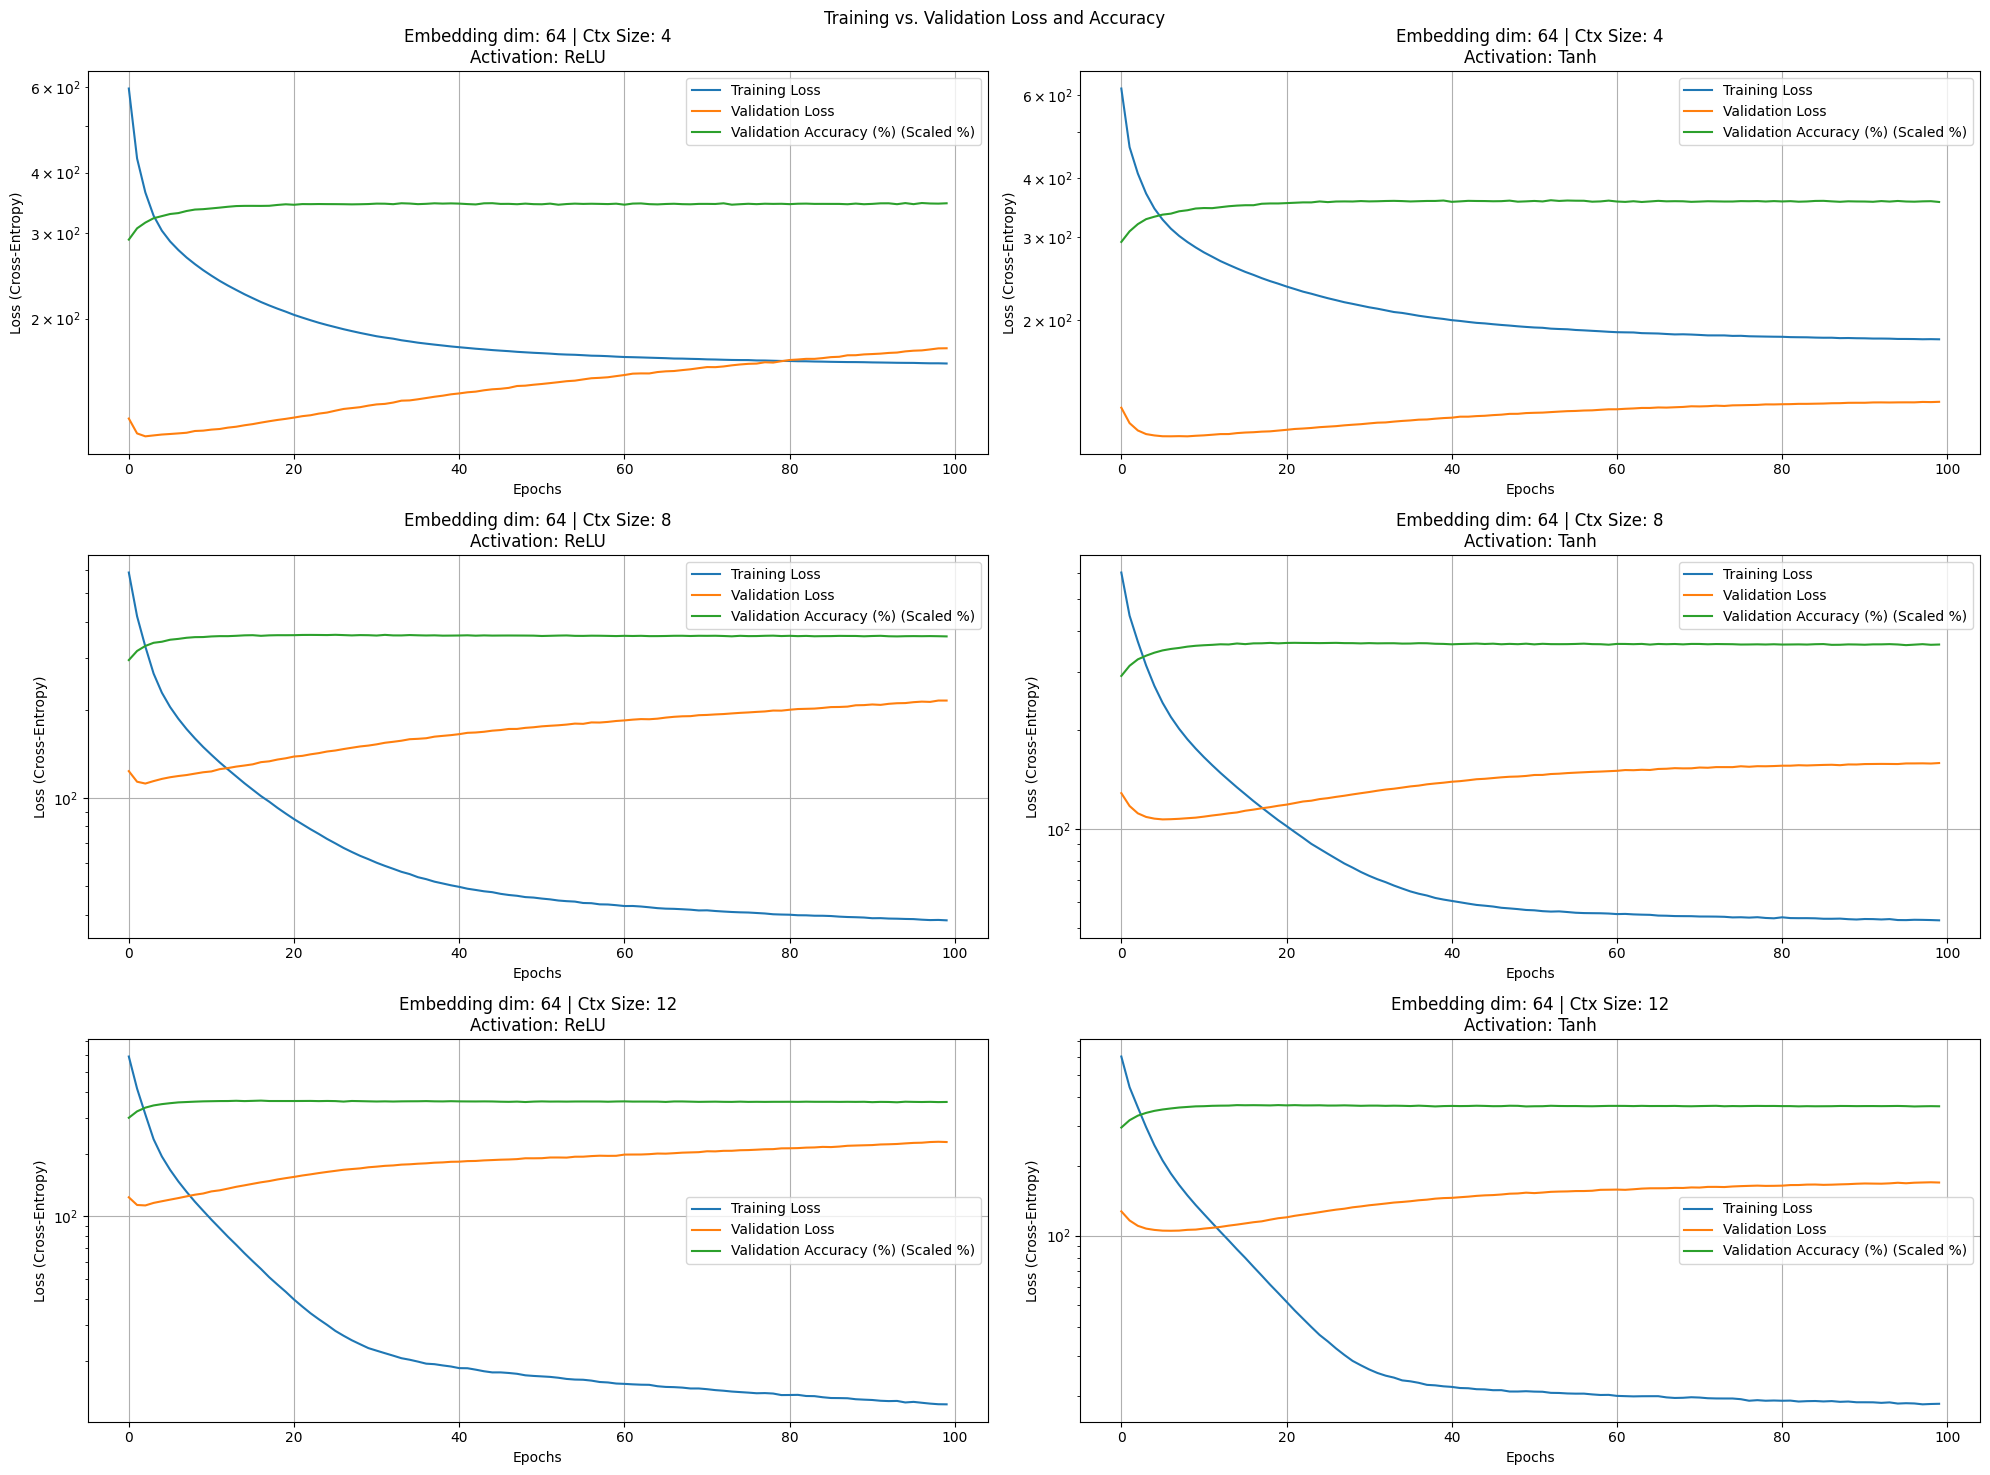

In [61]:
plot(True)

#### Best Model Category 2

In [63]:
datas.keys()


dict_keys(['./saved_models_q1_2/e64_c4_aTanh_arrays.json', './saved_models_q1_2/e64_c8_aTanh_arrays.json', './saved_models_q1_2/e64_c4_aReLU_arrays.json', './saved_models_q1_2/e64_c12_aReLU_arrays.json', './saved_models_q1_2/e64_c8_aReLU_arrays.json', './saved_models_q1_2/stoi_linux.json', './saved_models_q1_2/e64_c12_aTanh_arrays.json'])

In [64]:
best_overall_path = None
best_val_loss = float('inf')

for k, v in datas.items():
    if 'stoi_linux' in k:   # ✅ skip this extra JSON
        continue
    current_min = min(v['val_loss'])
    if current_min < best_val_loss:
        best_val_loss = current_min
        best_overall_path = k

best_overall_path = best_overall_path.replace('_arrays.json', '_best.pth')
best_overall_path


'./saved_models_q1_2/e64_c12_aTanh_best.pth'

/tmp/ipykernel_558942/2121021865.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_overall_path, map_location='cpu'))
/tmp/ipyke

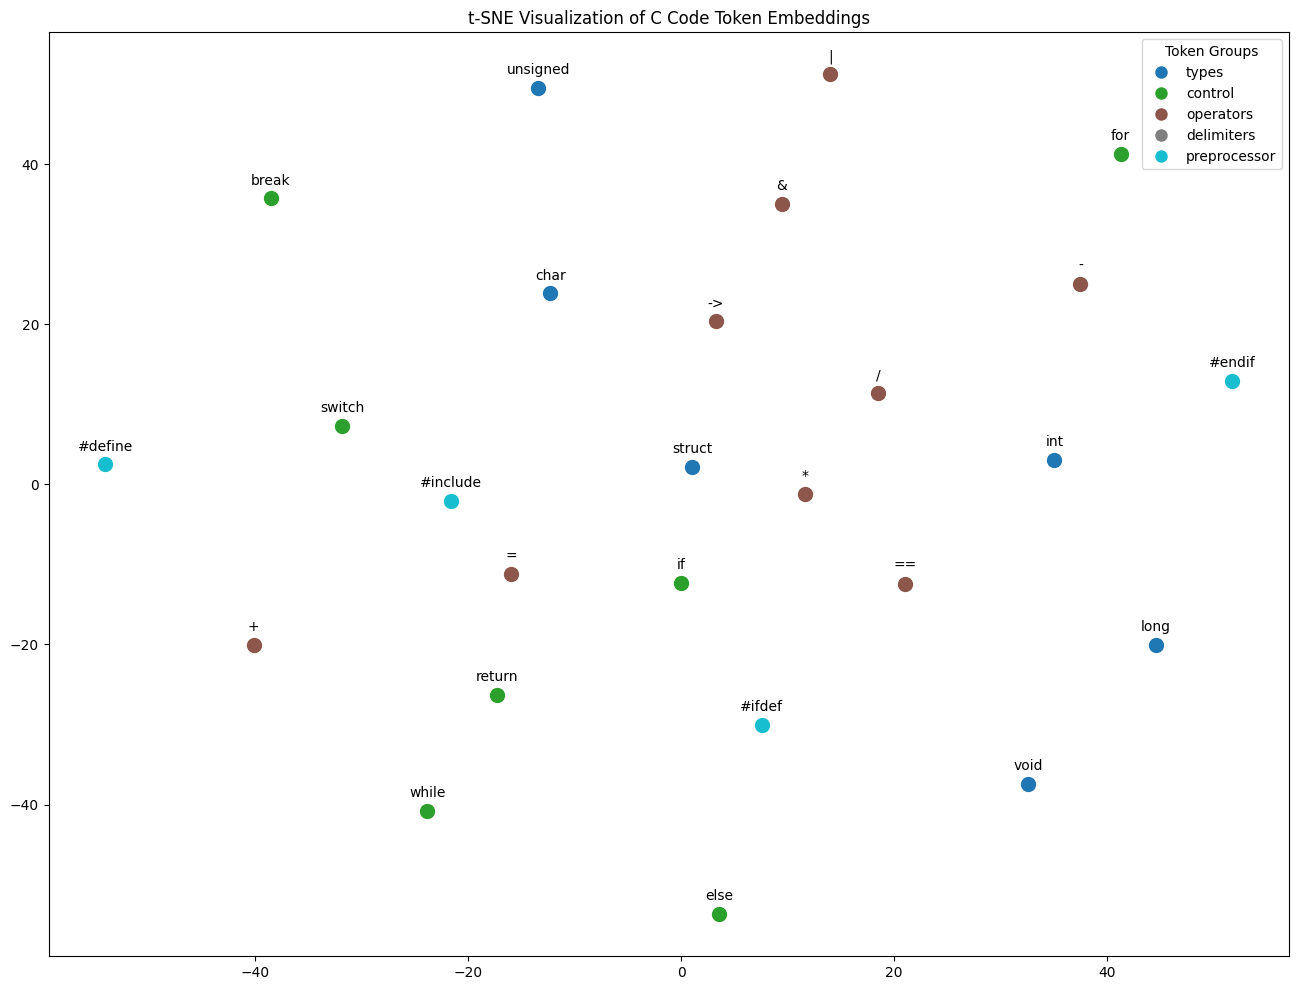

In [65]:
best_model = MLPTextGenerator(vocab_size, 64, 1024, 12, nn.Tanh()).to(device)
best_model.load_state_dict(torch.load(best_overall_path, map_location='cpu'))
best_model.to(device)
best_model.eval()
visualize_code_embeddings(best_model,stoi)

## 1.5 Comparative Analysis [1 mark]